In [39]:
import pandas as pd
from scipy.stats import ttest_rel
import numpy as np

df = pd.read_csv("pdcm_all_data.csv")
# Define network regions
network_rois = {
    "All Regions": list(range(100)),  
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 72)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 77)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 89)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau",
          "alpha_v", "beta_v", "alpha_e", "beta_e",
          "alpha", "E0"]

roi_to_network = {}
for net, rois in network_rois.items():
    for r in rois:
        roi_to_network[r] = net

df["network"] = df["roi"].map(roi_to_network)

# Pivot so each parameter is a separate column
df_pivot = df[df["parameter"].isin(params)].pivot_table(
    index=["subject", "roi", "experiment", "network"],
    columns="parameter",
    values="value"
).reset_index()

# Group by subject, network, condition and compute mean
network_agg = df_pivot.groupby(["subject", "network", "experiment"])[params].mean().reset_index()
network_agg.head()

from scipy.stats import ttest_rel

from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# interpret Cohen's d 
def interpret_d(d):
    if np.isnan(d):
        return "no data"
    abs_d = abs(d)
    if abs_d < 0.2:
        return "very small"
    elif abs_d < 0.5:
        return "small"
    elif abs_d < 0.8:
        return "medium"
    elif abs_d < 1.3:
        return "large"
    else:
        return "very large"


# Run t-tests per network and parameter
network_results = []

for param in params:
    for network in network_agg["network"].unique():
        net_data = network_agg[network_agg["network"] == network].pivot(index="subject", columns="experiment",
                                                                        values=param).dropna()
        if net_data.shape[0] < 3:
            continue

        diffs = net_data["LSD"] - net_data["PLCB"]
        mean_diff = diffs.mean()
        std_diff = diffs.std(ddof=1)
        cohen_d = mean_diff / std_diff if std_diff != 0 else np.nan
        t_stat, p_val = ttest_rel(net_data["LSD"], net_data["PLCB"])

        network_results.append({
            "network": network,
            "parameter": param,
            "mean_diff": mean_diff,
            "std_diff": std_diff,
            "t_stat": t_stat,
            "p_value": p_val,
            "cohen_d": cohen_d,
            "effect_size": interpret_d(cohen_d)
        })

network_df = pd.DataFrame(network_results)

#  Correction methods -
pvals = network_df["p_value"].fillna(1).values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

network_df["p_fdr_bh"] = p_fdr
network_df["reject_fdr_bh"] = rej_fdr
network_df["p_bonferroni"] = p_bonf
network_df["reject_bonferroni"] = rej_bonf
network_df["p_holm"] = p_holm
network_df["reject_holm"] = rej_holm
network_df["reject_raw"] = network_df["p_value"] < 0.05


def interpret_delta(p, mean):
    direction = "↑ LSD > PLCB" if mean > 0 else "↓ LSD < PLCB"
    if p < 0.001:
        return f"highly significant, {direction}"
    elif p < 0.01:
        return f"significant, {direction}"
    elif p < 0.05:
        return f"marginally significant, {direction}"
    else:
        return f"not significant, {direction}"


network_df["interpret_raw"] = network_df.apply(lambda row: interpret_delta(row["p_value"], row["mean_diff"]), axis=1)
network_df["interpret_fdr_bh"] = network_df.apply(lambda row: interpret_delta(row["p_fdr_bh"], row["mean_diff"]),
                                                  axis=1)
network_df["interpret_bonferroni"] = network_df.apply(
    lambda row: interpret_delta(row["p_bonferroni"], row["mean_diff"]), axis=1)
network_df["interpret_holm"] = network_df.apply(lambda row: interpret_delta(row["p_holm"], row["mean_diff"]), axis=1)


network_df = network_df[[
    "network", "parameter", "mean_diff", "std_diff", "cohen_d", "effect_size", "t_stat",
    "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

network_df.sort_values("network", inplace=True)
network_df.reset_index(drop=True, inplace=True)
network_df.to_csv("network_ttest_results.csv", index=False)

network_df



network parameter  mean_diff  std_diff   cohen_d effect_size  \
0    All Regions       phi   0.062514  0.251396  0.248668       small   
1    All Regions     alpha   0.021999  0.106616  0.206336       small   
2    All Regions       mtt   0.345215  1.625343  0.212395       small   
3    All Regions    beta_e  -0.367852  0.936640 -0.392736       small   
4    All Regions       chi   0.076437  0.204696  0.373416       small   
..           ...       ...        ...       ...       ...         ...   
160    RH Visual       mtt   0.033661  0.692188  0.048630  very small   
161    RH Visual       phi  -0.061174  0.130259 -0.469630       small   
162    RH Visual     alpha   0.008015  0.050897  0.157466  very small   
163    RH Visual       tau   0.368238  3.417529  0.107750  very small   
164    RH Visual        E0  -0.032556  0.058360 -0.557856      medium   

       t_stat   p_value  reject_raw                         interpret_raw  \
0    0.861411  0.407397       False         not significant, ↑ LSD > PLCB   
1    0.714768  0.489644       False         not significant, ↑ LSD > PLCB   
2    0.735759  0.477274       False         not significant, ↑ LSD > PLCB   
3   -1.360478  0.200904       False         not significant, ↓ LSD < PLCB   
4    1.293552  0.222323       False         not significant, ↑ LSD > PLCB   
..        ...       ...         ...                                   ...   
160  0.188343  0.853311       False         not significant, ↑ LSD > PLCB   
161 -1.818868  0.090382       False         not significant, ↓ LSD < PLCB   
162  0.609862  0.551724       False         not significant, ↑ LSD > PLCB   
163  0.417313  0.682778       False         not significant, ↑ LSD > PLCB   
164 -2.160567  0.048551        True  marginally significant, ↓ LSD < PLCB   

     p_fdr_bh  reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0    0.829884          False  not significant, ↑ LSD > PLCB           1.0   
1    0.890345          False  not significant, ↑ LSD > PLCB           1.0   
2    0.884833          False  not significant, ↑ LSD > PLCB           1.0   
3    0.811768          False  not significant, ↓ LSD < PLCB           1.0   
4    0.811768          False  not significant, ↑ LSD > PLCB           1.0   
..        ...            ...                            ...           ...   
160  0.938642          False  not significant, ↑ LSD > PLCB           1.0   
161  0.589148          False  not significant, ↓ LSD < PLCB           1.0   
162  0.922975          False  not significant, ↑ LSD > PLCB           1.0   
163  0.938642          False  not significant, ↑ LSD > PLCB           1.0   
164  0.589148          False  not significant, ↓ LSD < PLCB           1.0   

     reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0                False  not significant, ↑ LSD > PLCB     1.0        False   
1                False  not significant, ↑ LSD > PLCB     1.0        False   
2                False  not significant, ↑ LSD > PLCB     1.0        False   
3                False  not significant, ↓ LSD < PLCB     1.0        False   
4                False  not significant, ↑ LSD > PLCB     1.0        False   
..                 ...                            ...     ...          ...   
160              False  not significant, ↑ LSD > PLCB     1.0        False   
161              False  not significant, ↓ LSD < PLCB     1.0        False   
162              False  not significant, ↑ LSD > PLCB     1.0        False   
163              False  not significant, ↑ LSD > PLCB     1.0        False   
164              False  not significant, ↓ LSD < PLCB     1.0        False   

                    interpret_holm  
0    not significant, ↑ LSD > PLCB  
1    not significant, ↑ LSD > PLCB  
2    not significant, ↑ LSD > PLCB  
3    not significant, ↓ LSD < PLCB  
4    not significant, ↑ LSD > PLCB  
..                             ...  
160  not significant, ↑ LSD > PLCB  
161  not significant, ↓ LSD < PLCB  
162  not sig

In [40]:
significant_uncorrected = network_df[network_df["reject_raw"] == True]
significant_uncorrected


network parameter  mean_diff  std_diff   cohen_d  \
12                      LH Control       chi   0.073587  0.123205  0.597271   
14                      LH Control   alpha_e  -2.430111  3.186693 -0.762581   
24                 LH Default Mode       chi   0.051507  0.088349  0.582993   
38             LH Dorsal Attention    varphi   0.065031  0.105200  0.618171   
58   LH Salience/Ventral Attention    varphi   0.091189  0.118264  0.771060   
85                       LH Visual       phi   0.091158  0.123855  0.736004   
100                RH Default Mode   alpha_e   1.734093  2.349911  0.737940   
103                RH Default Mode     alpha   0.028426  0.028117  1.010963   
130                      RH Limbic   alpha_e   3.320994  4.115335  0.806980   
144                 RH Somatomotor   alpha_v  -1.281468  2.298204 -0.557595   
154                      RH Visual       chi   0.078881  0.111734  0.705966   
164                      RH Visual        E0  -0.032556  0.058360 -0.557856   

    effect_size    t_stat   p_value  reject_raw  \
12       medium  2.313222  0.036425        True   
14       medium -2.953462  0.010474        True   
24       medium  2.257922  0.040445        True   
38       medium  2.394166  0.031216        True   
58       medium  2.986304  0.009814        True   
85       medium  2.850531  0.012836        True   
100      medium  2.447470  0.034406        True   
103       large  3.352985  0.007328        True   
130       large  2.795461  0.017416        True   
144      medium -2.159558  0.048643        True   
154      medium  2.734196  0.016138        True   
164      medium -2.160567  0.048551        True   

                            interpret_raw  p_fdr_bh  reject_fdr_bh  \
12   marginally significant, ↑ LSD > PLCB  0.589148          False   
14   marginally significant, ↓ LSD < PLCB  0.478929          False   
24   marginally significant, ↑ LSD > PLCB  0.589148          False   
38   marginally significant, ↑ LSD > PLCB  0.589148          False   
58              significant, ↑ LSD > PLCB  0.478929          False   
85   marginally significant, ↑ LSD > PLCB  0.478929          False   
100  marginally significant, ↑ LSD > PLCB  0.589148          False   
103             significant, ↑ LSD > PLCB  0.478929          False   
130  marginally significant, ↑ LSD > PLCB  0.478929          False   
144  marginally significant, ↓ LSD < PLCB  0.589148          False   
154  marginally significant, ↑ LSD > PLCB  0.478929          False   
164  marginally significant, ↓ LSD < PLCB  0.589148          False   

                  interpret_fdr_bh  p_bonferroni  reject_bonferroni  \
12   not significant, ↑ LSD > PLCB           1.0              False   
14   not significant, ↓ LSD < PLCB           1.0              False   
24   not significant, ↑ LSD > PLCB           1.0              False   
38   not significant, ↑ LSD > PLCB           1.0              False   
58   not significant, ↑ LSD > PLCB           1.0              False   
85   not significant, ↑ LSD > PLCB           1.0              False   
100  not significant, ↑ LSD > PLCB           1.0              False   
103  not significant, ↑ LSD > PLCB           1.0              False   
130  not significant, ↑ LSD > PLCB           1.0              False   
144  not significant, ↓ LSD < PLCB           1.0              False   
154  not significant, ↑ LSD > PLCB           1.0              False   
164  not significant, ↓ LSD < PLCB           1.0              False   

              interpret_bonferroni  p_holm  reject_holm  \
12   not significant, ↑ LSD > PLCB     1.0        False   
14   not significant, ↓ LSD < PLCB     1.0        False   
24   not significant, ↑ LSD > PLCB     1.0        False   
38   not significant, ↑ LSD > PLCB     1.0        False   
58   not significant, ↑ LSD > PLCB     1.0        False   
85   not significant, ↑ LSD > PLCB     1.0        False   
100  not significant, ↑ LSD > PLCB     1.0        False   
103  not significant, ↑ LSD 

In [41]:
# FDR BH significant
sig_fdr = network_df[network_df["reject_fdr_bh"] == True]
sig_fdr

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [42]:
# Bonferroni significant
sig_bonf = network_df[network_df["reject_bonferroni"] == True]
sig_bonf

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [43]:
# Holm significant
sig_holm = network_df[network_df["reject_holm"] == True]
sig_holm

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [44]:
# Filter where the tests show significant difference
sig = network_df[
    (network_df["reject_raw"] == True) &
    (network_df["reject_fdr_bh"] == True) &
    (network_df["reject_bonferroni"] == True) &
    (network_df["reject_holm"] == True)
    ]


sig = sig.sort_values("network")


sig


Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

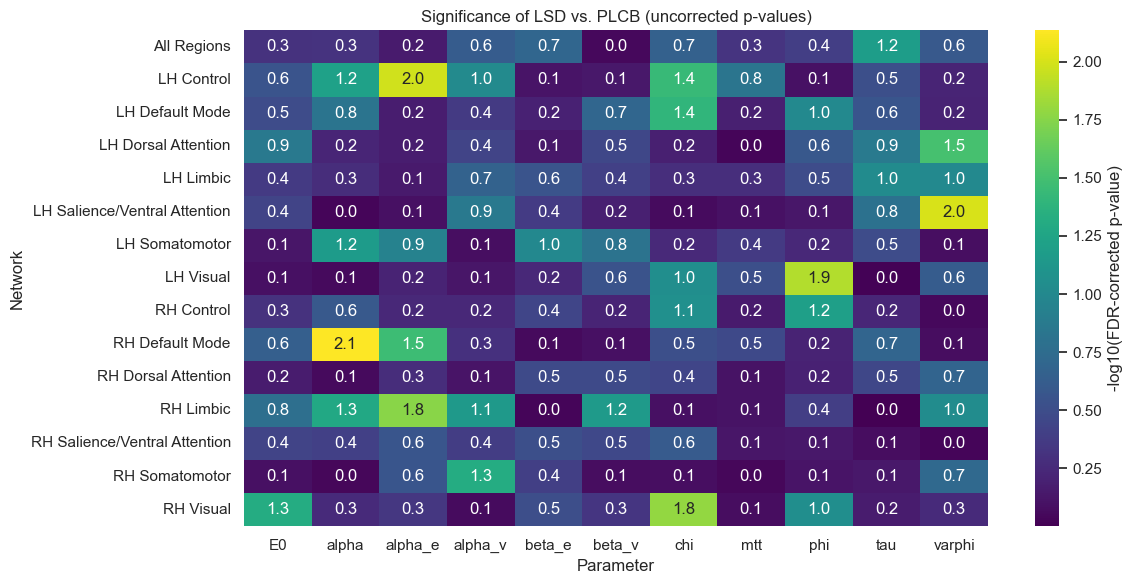

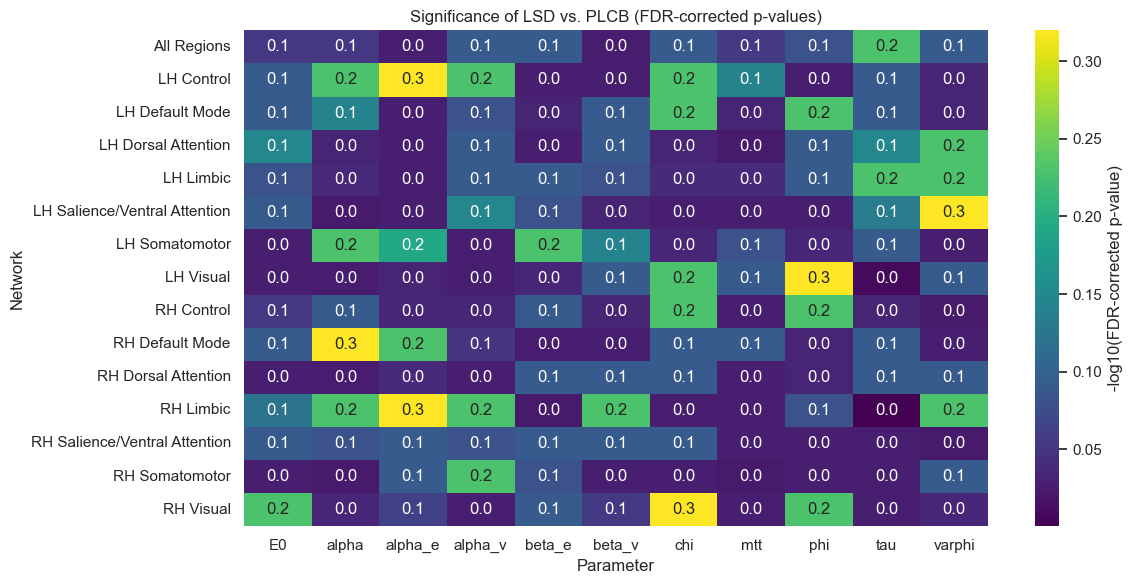

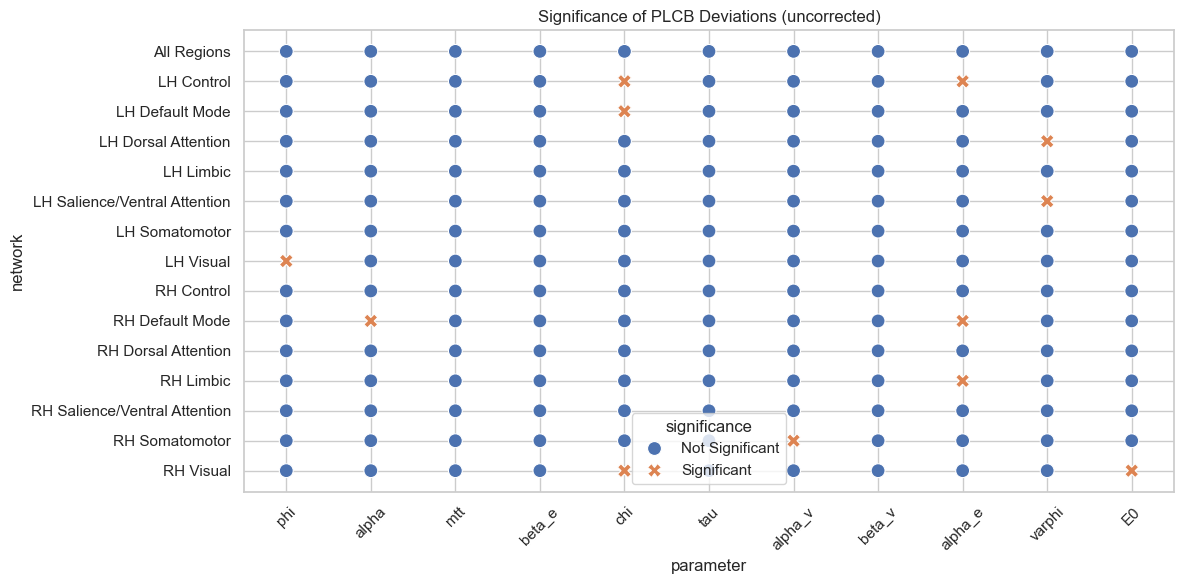

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pivot p-values for heatmap 
heatmap_data_uncorrected = network_df.pivot(index="network", columns="parameter", values="p_value")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_data_uncorrected),
    cmap="viridis",
    cbar_kws={"label": "-log10(FDR-corrected p-value)"},
    annot=True, fmt=".1f"
)
plt.title("Significance of LSD vs. PLCB (uncorrected p-values)")
plt.ylabel("Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Pivot p-values for heatmap 
heatmap_data = network_df.pivot(index="network", columns="parameter", values="p_fdr_bh")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_data),
    cmap="viridis",
    cbar_kws={"label": "-log10(FDR-corrected p-value)"},
    annot=True, fmt=".1f"
)
plt.title("Significance of LSD vs. PLCB (FDR-corrected p-values)")
plt.ylabel("Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

#reject_fdr_bh
#reject_bonferroni
#reject_holm

# Mark significance status
network_df["significance"] = network_df["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=network_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of PLCB Deviations (uncorrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



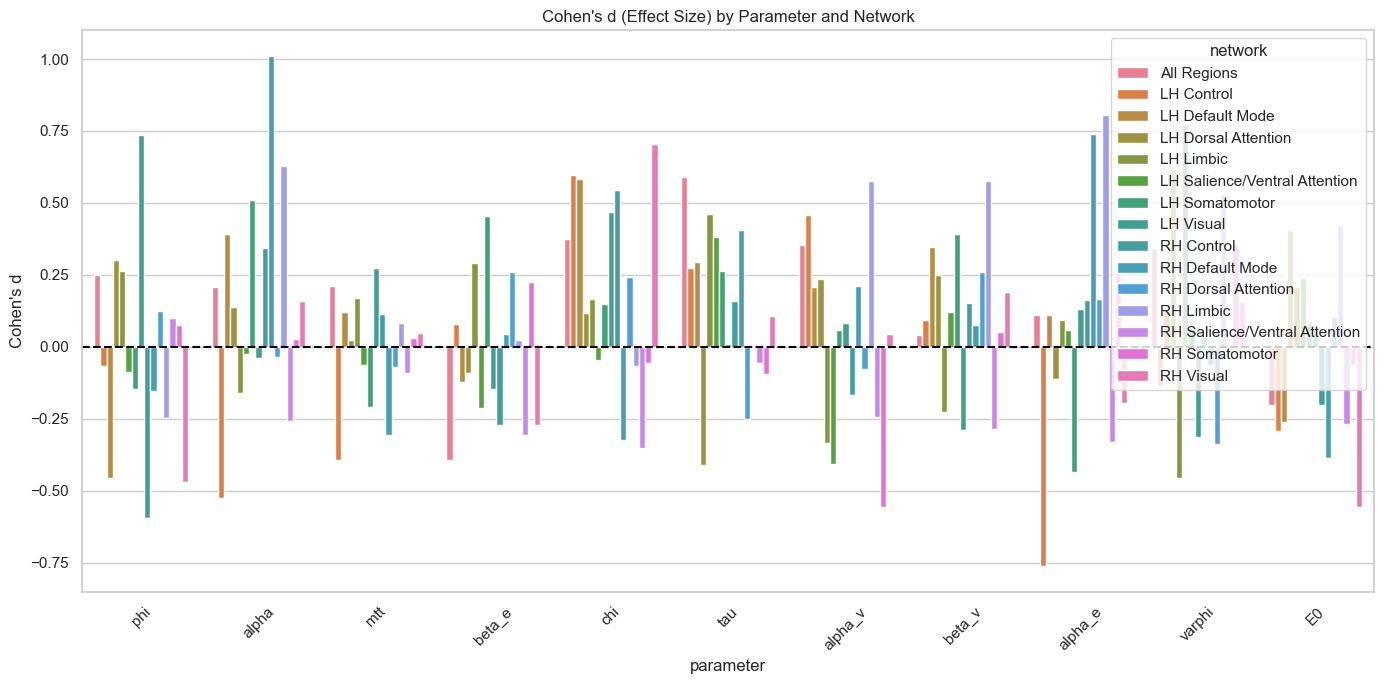

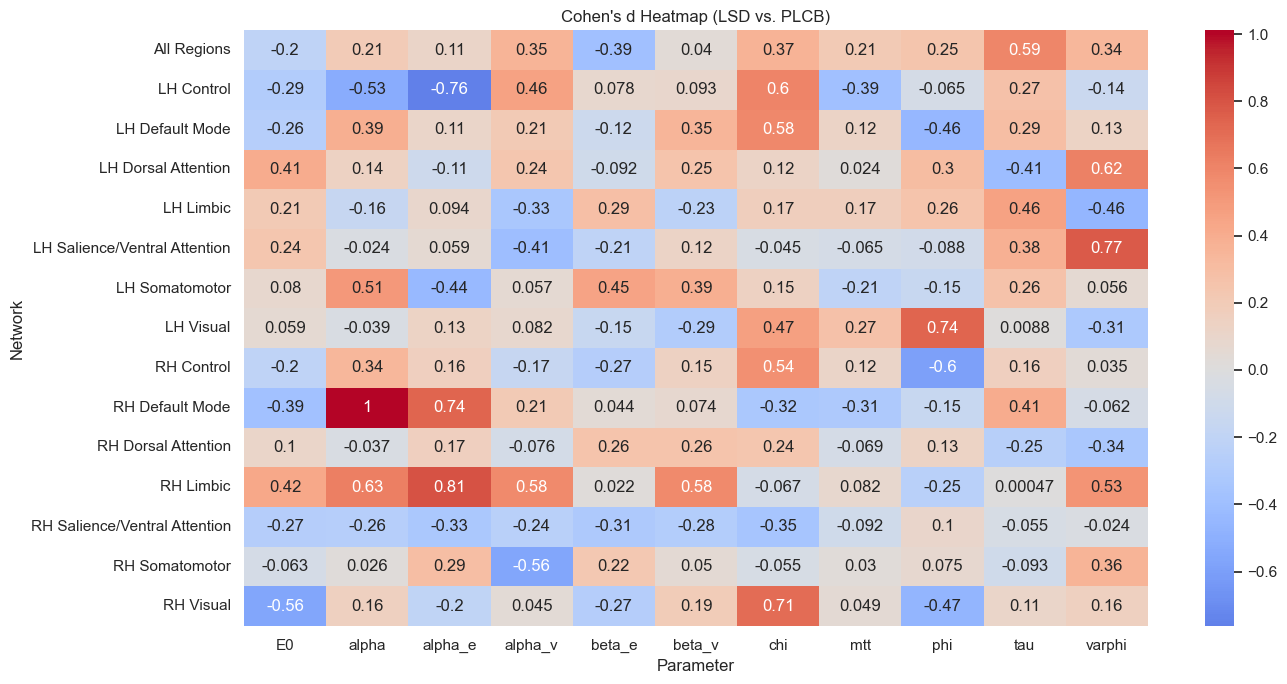

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(
    data=network_df,
    x="parameter", y="cohen_d",
    hue="network",
    dodge=True
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Cohen's d (Effect Size) by Parameter and Network")
plt.ylabel("Cohen's d")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot_d = network_df.pivot(index="network", columns="parameter", values="cohen_d")

plt.figure(figsize=(14, 7))
sns.heatmap(pivot_d, annot=True, cmap="coolwarm", center=0)
plt.title("Cohen's d Heatmap (LSD vs. PLCB)")
plt.xlabel("Parameter")
plt.ylabel("Network")
plt.tight_layout()
plt.show()




paired test for each roi

In [47]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

df = pd.read_csv("pdcm_all_data.csv")

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau",
          "alpha", "E0", "sigma", "mu", "lamb","alpha_v", "beta_v", "alpha_e", "beta_e"]

# Pivot so each parameter is a separate column
df_pivot = df[df["parameter"].isin(params)].pivot_table(
    index=["subject", "roi", "experiment"],
    columns="parameter",
    values="value"
).reset_index()

# Group by subject, ROI, experiment and compute mean values
roi_agg = df_pivot.groupby(["subject", "roi", "experiment"])[params].mean().reset_index()

def interpret_d(d):
    if np.isnan(d):
        return "no data"
    abs_d = abs(d)
    if abs_d < 0.2:
        return "very small"
    elif abs_d < 0.5:
        return "small"
    elif abs_d < 0.8:
        return "medium"
    elif abs_d < 1.3:
        return "large"
    else:
        return "very large"


# Run t-tests per ROI and parameter 
roi_results = []

for param in params:
    for roi in roi_agg["roi"].unique():
        roi_data = roi_agg[roi_agg["roi"] == roi].pivot(index="subject", columns="experiment", values=param).dropna()

        if roi_data.shape[0] < 3:
            continue

        diffs = roi_data["LSD"] - roi_data["PLCB"]
        mean_diff = diffs.mean()
        std_diff = diffs.std(ddof=1)
        cohen_d = mean_diff / std_diff if std_diff != 0 else np.nan
        t_stat, p_val = ttest_rel(roi_data["LSD"], roi_data["PLCB"])

        roi_results.append({
            "roi": roi,
            "parameter": param,
            "mean_diff": mean_diff,
            "std_diff": std_diff,
            "t_stat": t_stat,
            "p_value": p_val,
            "cohen_d": cohen_d,
            "effect_size": interpret_d(cohen_d)
        })

roi_df = pd.DataFrame(roi_results)

pvals = roi_df["p_value"].fillna(1).values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

roi_df["p_fdr_bh"] = p_fdr
roi_df["reject_fdr_bh"] = rej_fdr
roi_df["p_bonferroni"] = p_bonf
roi_df["reject_bonferroni"] = rej_bonf
roi_df["p_holm"] = p_holm
roi_df["reject_holm"] = rej_holm
roi_df["reject_raw"] = roi_df["p_value"] < 0.05


def interpret_delta(p, mean):
    direction = "↑ LSD > PLCB" if mean > 0 else "↓ LSD < PLCB"
    if p < 0.001:
        return f"highly significant, {direction}"
    elif p < 0.01:
        return f"significant, {direction}"
    elif p < 0.05:
        return f"marginally significant, {direction}"
    else:
        return f"not significant, {direction}"


roi_df["interpret_raw"] = roi_df.apply(lambda row: interpret_delta(row["p_value"], row["mean_diff"]), axis=1)
roi_df["interpret_fdr_bh"] = roi_df.apply(lambda row: interpret_delta(row["p_fdr_bh"], row["mean_diff"]), axis=1)
roi_df["interpret_bonferroni"] = roi_df.apply(lambda row: interpret_delta(row["p_bonferroni"], row["mean_diff"]),
                                              axis=1)
roi_df["interpret_holm"] = roi_df.apply(lambda row: interpret_delta(row["p_holm"], row["mean_diff"]), axis=1)

roi_df = roi_df[[
    "roi", "parameter", "mean_diff", "std_diff", "cohen_d", "effect_size", "t_stat",
    "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

roi_df.sort_values(["roi", "parameter"], inplace=True)
roi_df.reset_index(drop=True, inplace=True)
roi_df.to_csv("roi_ttest_results.csv", index=False)
roi_df


roi parameter  mean_diff   std_diff   cohen_d effect_size    t_stat  \
0       0        E0   0.055975   0.174770  0.320279       small  1.240434   
1       0     alpha  -0.041783   0.176561 -0.236652       small -0.916547   
2       0   alpha_e  -1.622821   7.065114 -0.229695       small -0.889605   
3       0   alpha_v  -1.547957   8.506191 -0.181980  very small -0.704806   
4       0    beta_e  -1.022832   2.179009 -0.469402       small -1.817987   
...   ...       ...        ...        ...       ...         ...       ...   
1395   99        mu   0.519323   0.752881  0.689780      medium  2.181277   
1396   99       phi  -0.132633   0.524538 -0.252857       small -0.799606   
1397   99     sigma   0.291558   0.322434  0.904242       large  2.859464   
1398   99       tau  -3.414116  11.263187 -0.303122       small -0.958555   
1399   99    varphi  -0.088442   0.363443 -0.243344       small -0.769521   

       p_value  reject_raw                         interpret_raw  p_fdr_bh  \
0     0.235202       False         not significant, ↑ LSD > PLCB  0.924457   
1     0.374899       False         not significant, ↓ LSD < PLCB  0.961221   
2     0.388709       False         not significant, ↓ LSD < PLCB  0.961221   
3     0.492491       False         not significant, ↓ LSD < PLCB  0.984144   
4     0.090523       False         not significant, ↓ LSD < PLCB  0.924457   
...        ...         ...                                   ...       ...   
1395  0.057056       False         not significant, ↑ LSD > PLCB  0.905038   
1396  0.444530       False         not significant, ↓ LSD < PLCB  0.980916   
1397  0.018797        True  marginally significant, ↑ LSD > PLCB  0.780099   
1398  0.362824       False         not significant, ↓ LSD < PLCB  0.961221   
1399  0.461302       False         not significant, ↓ LSD < PLCB  0.983950   

      reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0             False  not significant, ↑ LSD > PLCB           1.0   
1             False  not significant, ↓ LSD < PLCB           1.0   
2             False  not significant, ↓ LSD < PLCB           1.0   
3             False  not significant, ↓ LSD < PLCB           1.0   
4             False  not significant, ↓ LSD < PLCB           1.0   
...             ...                            ...           ...   
1395          False  not significant, ↑ LSD > PLCB           1.0   
1396          False  not significant, ↓ LSD < PLCB           1.0   
1397          False  not significant, ↑ LSD > PLCB           1.0   
1398          False  not significant, ↓ LSD < PLCB           1.0   
1399          False  not significant, ↓ LSD < PLCB           1.0   

      reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0                 False  not significant, ↑ LSD > PLCB     1.0        False   
1                 False  not significant, ↓ LSD < PLCB     1.0        False   
2                 False  not significant, ↓ LSD < PLCB     1.0        False   
3                 False  not significant, ↓ LSD < PLCB     1.0        False   
4                 False  not significant, ↓ LSD < PLCB     1.0        False   
...                 ...                            ...     ...          ...   
1395              False  not significant, ↑ LSD > PLCB     1.0        False   
1396              False  not significant, ↓ LSD < PLCB     1.0        False   
1397              False  not significant, ↑ LSD > PLCB     1.0        False   
1398              False  not significant, ↓ LSD < PLCB     1.0        False   
1399              False  not significant, ↓ LSD < PLCB     1.0        False   

                     interpret_holm  
0     not significant, ↑ LSD > PLCB  
1     not significant, ↓ LSD < PLCB  
2     not significant, ↓ LSD < PLCB  
3     not significant, ↓ LSD < PLCB  
4     not significant, ↓ LSD < PLCB  
...                             ...  
1395  not significant, ↑ LSD > PLCB  
1396  not significant, ↓ LSD < PLCB  
1397  not significant, ↑ LSD > PLCB 

In [48]:
significant_uncorrected_roi = roi_df[roi_df["reject_raw"] == True]
significant_uncorrected_roi


roi parameter  mean_diff  std_diff   cohen_d effect_size    t_stat  \
6       0       chi   0.184047  0.284076  0.647880      medium  2.509229   
23      1        mu  -0.306152  0.484761 -0.631552      medium -2.445989   
61      4    beta_v  -0.750160  0.866548 -0.865688       large -3.352794   
94      6       phi   0.267255  0.443934  0.602015      medium  2.331595   
103     7    beta_v  -1.281266  1.755616 -0.729810      medium -2.826543   
...   ...       ...        ...       ...       ...         ...       ...   
1297   92        mu  -0.414451  0.540086 -0.767379      medium -2.545109   
1316   94        E0  -0.103125  0.136679 -0.754502      medium -2.502399   
1354   96       phi  -0.245083  0.213790 -1.146375       large -3.802095   
1370   97       tau   6.398059  8.047392  0.795048      medium  2.636874   
1397   99     sigma   0.291558  0.322434  0.904242       large  2.859464   

       p_value  reject_raw                         interpret_raw  p_fdr_bh  \
6     0.025016        True  marginally significant, ↑ LSD > PLCB  0.813854   
23    0.028261        True  marginally significant, ↓ LSD < PLCB  0.813854   
61    0.004738        True             significant, ↓ LSD < PLCB  0.634625   
94    0.035175        True  marginally significant, ↑ LSD > PLCB  0.820746   
103   0.013458        True  marginally significant, ↓ LSD < PLCB  0.780099   
...        ...         ...                                   ...       ...   
1297  0.029107        True  marginally significant, ↓ LSD < PLCB  0.813854   
1316  0.031318        True  marginally significant, ↓ LSD < PLCB  0.813854   
1354  0.003474        True             significant, ↓ LSD < PLCB  0.634625   
1370  0.024867        True  marginally significant, ↑ LSD > PLCB  0.813854   
1397  0.018797        True  marginally significant, ↑ LSD > PLCB  0.780099   

      reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
6             False  not significant, ↑ LSD > PLCB           1.0   
23            False  not significant, ↓ LSD < PLCB           1.0   
61            False  not significant, ↓ LSD < PLCB           1.0   
94            False  not significant, ↑ LSD > PLCB           1.0   
103           False  not significant, ↓ LSD < PLCB           1.0   
...             ...                            ...           ...   
1297          False  not significant, ↓ LSD < PLCB           1.0   
1316          False  not significant, ↓ LSD < PLCB           1.0   
1354          False  not significant, ↓ LSD < PLCB           1.0   
1370          False  not significant, ↑ LSD > PLCB           1.0   
1397          False  not significant, ↑ LSD > PLCB           1.0   

      reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
6                 False  not significant, ↑ LSD > PLCB     1.0        False   
23                False  not significant, ↓ LSD < PLCB     1.0        False   
61                False  not significant, ↓ LSD < PLCB     1.0        False   
94                False  not significant, ↑ LSD > PLCB     1.0        False   
103               False  not significant, ↓ LSD < PLCB     1.0        False   
...                 ...                            ...     ...          ...   
1297              False  not significant, ↓ LSD < PLCB     1.0        False   
1316              False  not significant, ↓ LSD < PLCB     1.0        False   
1354              False  not significant, ↓ LSD < PLCB     1.0        False   
1370              False  not significant, ↑ LSD > PLCB     1.0        False   
1397              False  not significant, ↑ LSD > PLCB     1.0        False   

                     interpret_holm  
6     not significant, ↑ LSD > PLCB  
23    not significant, ↓ LSD < PLCB  
61    not significant, ↓ LSD < PLCB  
94    not significant, ↑ LSD > PLCB  
103   not significant, ↓ LSD < PLCB  
...                             ...  
1297  not significant, ↓ LSD < PLCB  
1316  not significant, ↓ LSD < PLCB  
1354  not significant, ↓ LSD < PLCB  
1370  not 

In [49]:
# Bonferroni significant
sig_bonf_roi = roi_df[roi_df["reject_bonferroni"] == True]
sig_bonf_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [50]:
# FDR BH significant
sig_fdr_roi = roi_df[roi_df["reject_fdr_bh"] == True]
sig_fdr_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [51]:
# Holm significant
sig_holm_roi = roi_df[roi_df["reject_holm"] == True]
sig_holm_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [52]:
# Filter where the tests show significant difference
sig_roi = roi_df[
    (roi_df["reject_raw"] == True) &
    (roi_df["reject_fdr_bh"] == True) &
    (roi_df["reject_bonferroni"] == True) &
    (roi_df["reject_holm"] == True)
    ]

sig_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, effect_size, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

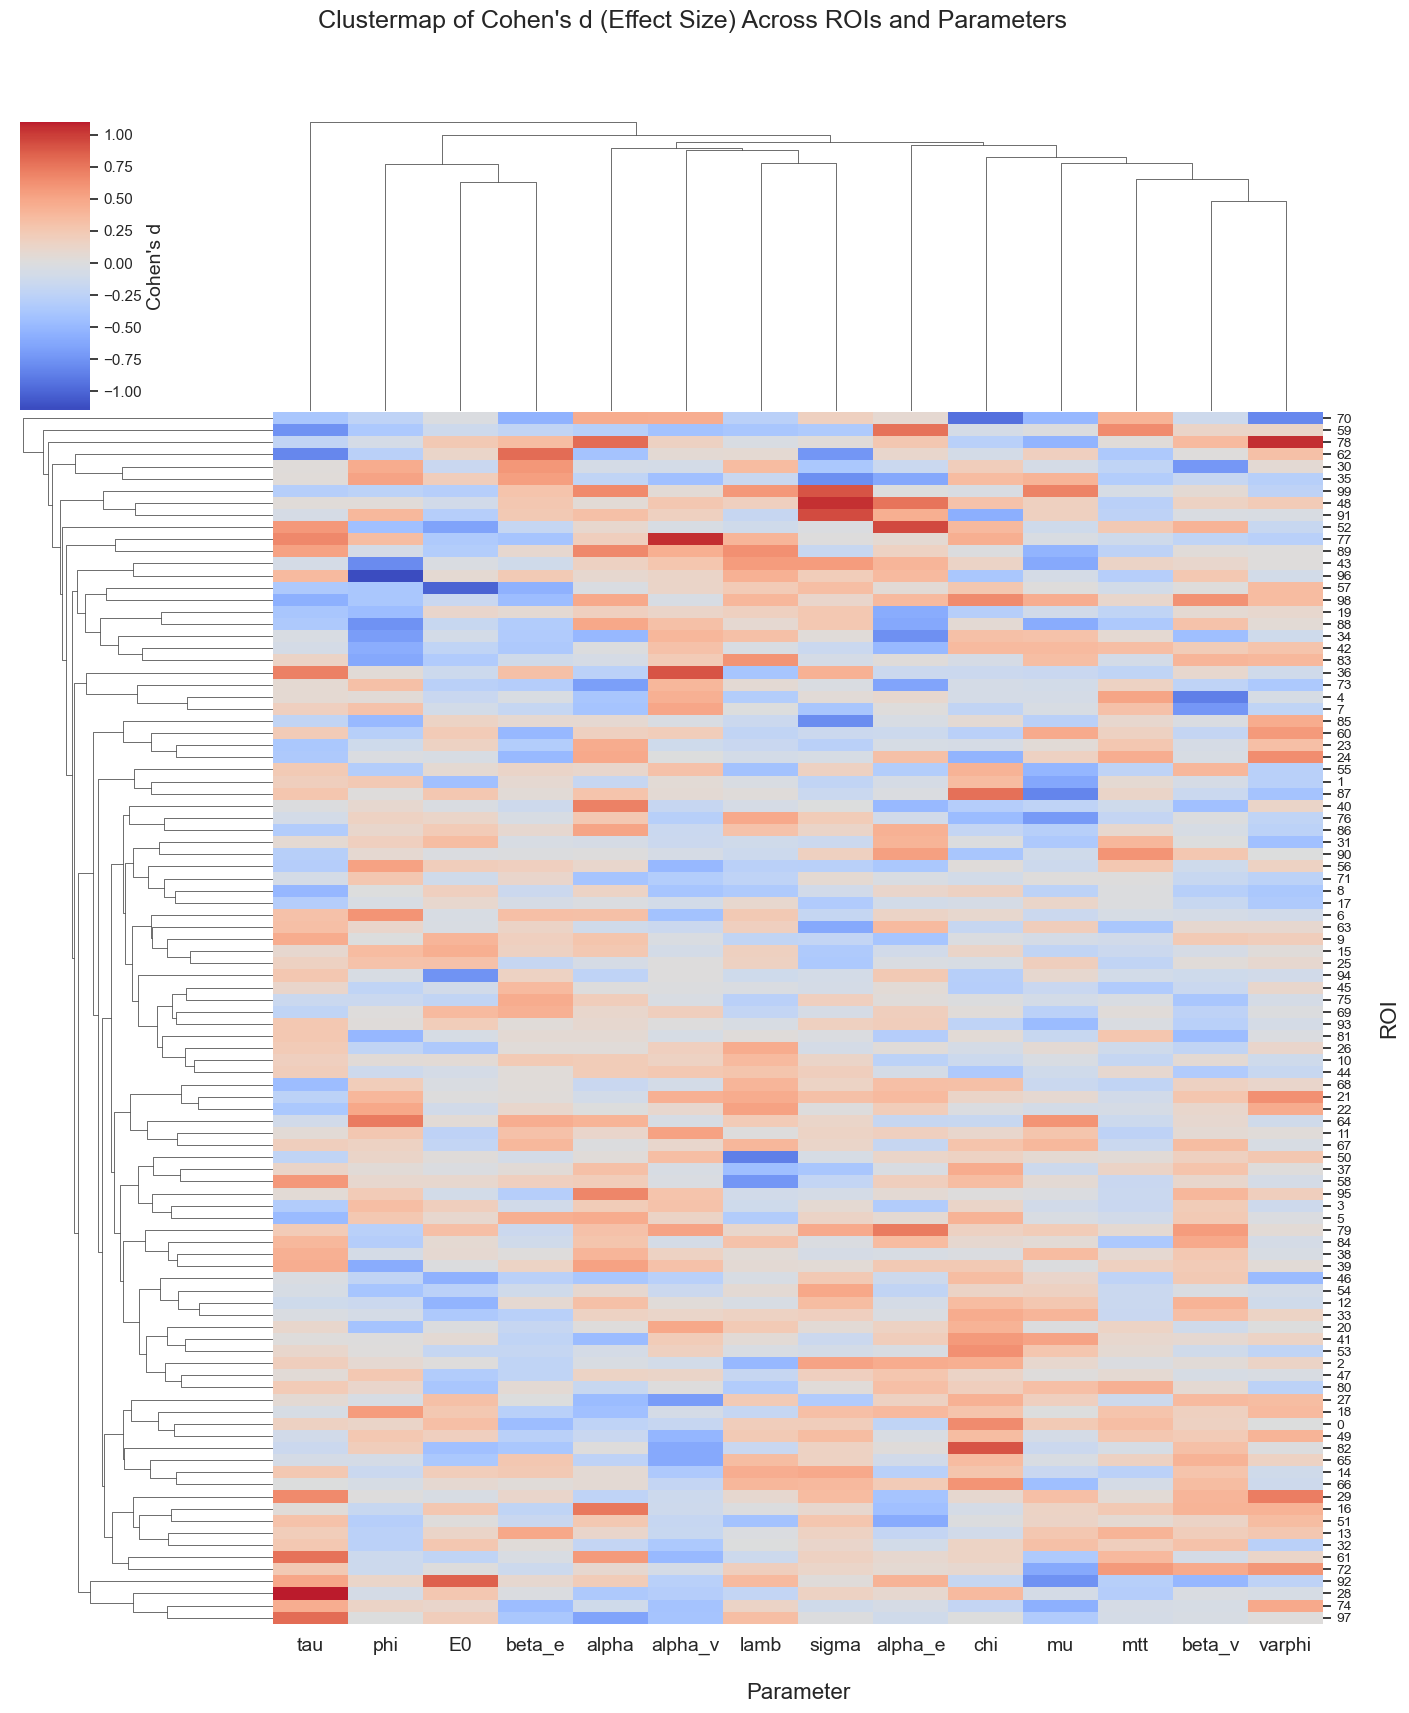

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame
pivot_d = roi_df.pivot(index="roi", columns="parameter", values="cohen_d")

h = sns.clustermap(
    pivot_d,
    cmap="coolwarm", center=0,
    figsize=(14, 16),
    yticklabels=True,
    annot=False
)

h.fig.suptitle("Clustermap of Cohen's d (Effect Size) Across ROIs and Parameters", y=1.05, fontsize=18)

plt.setp(h.ax_heatmap.xaxis.get_majorticklabels(), fontsize=14)

plt.setp(h.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)

h.cax.set_ylabel("Cohen's d", fontsize=14)

h.ax_heatmap.set_xlabel("Parameter", fontsize=16, labelpad=20)

h.ax_heatmap.set_ylabel("ROI", fontsize=16, labelpad=20)

plt.show()


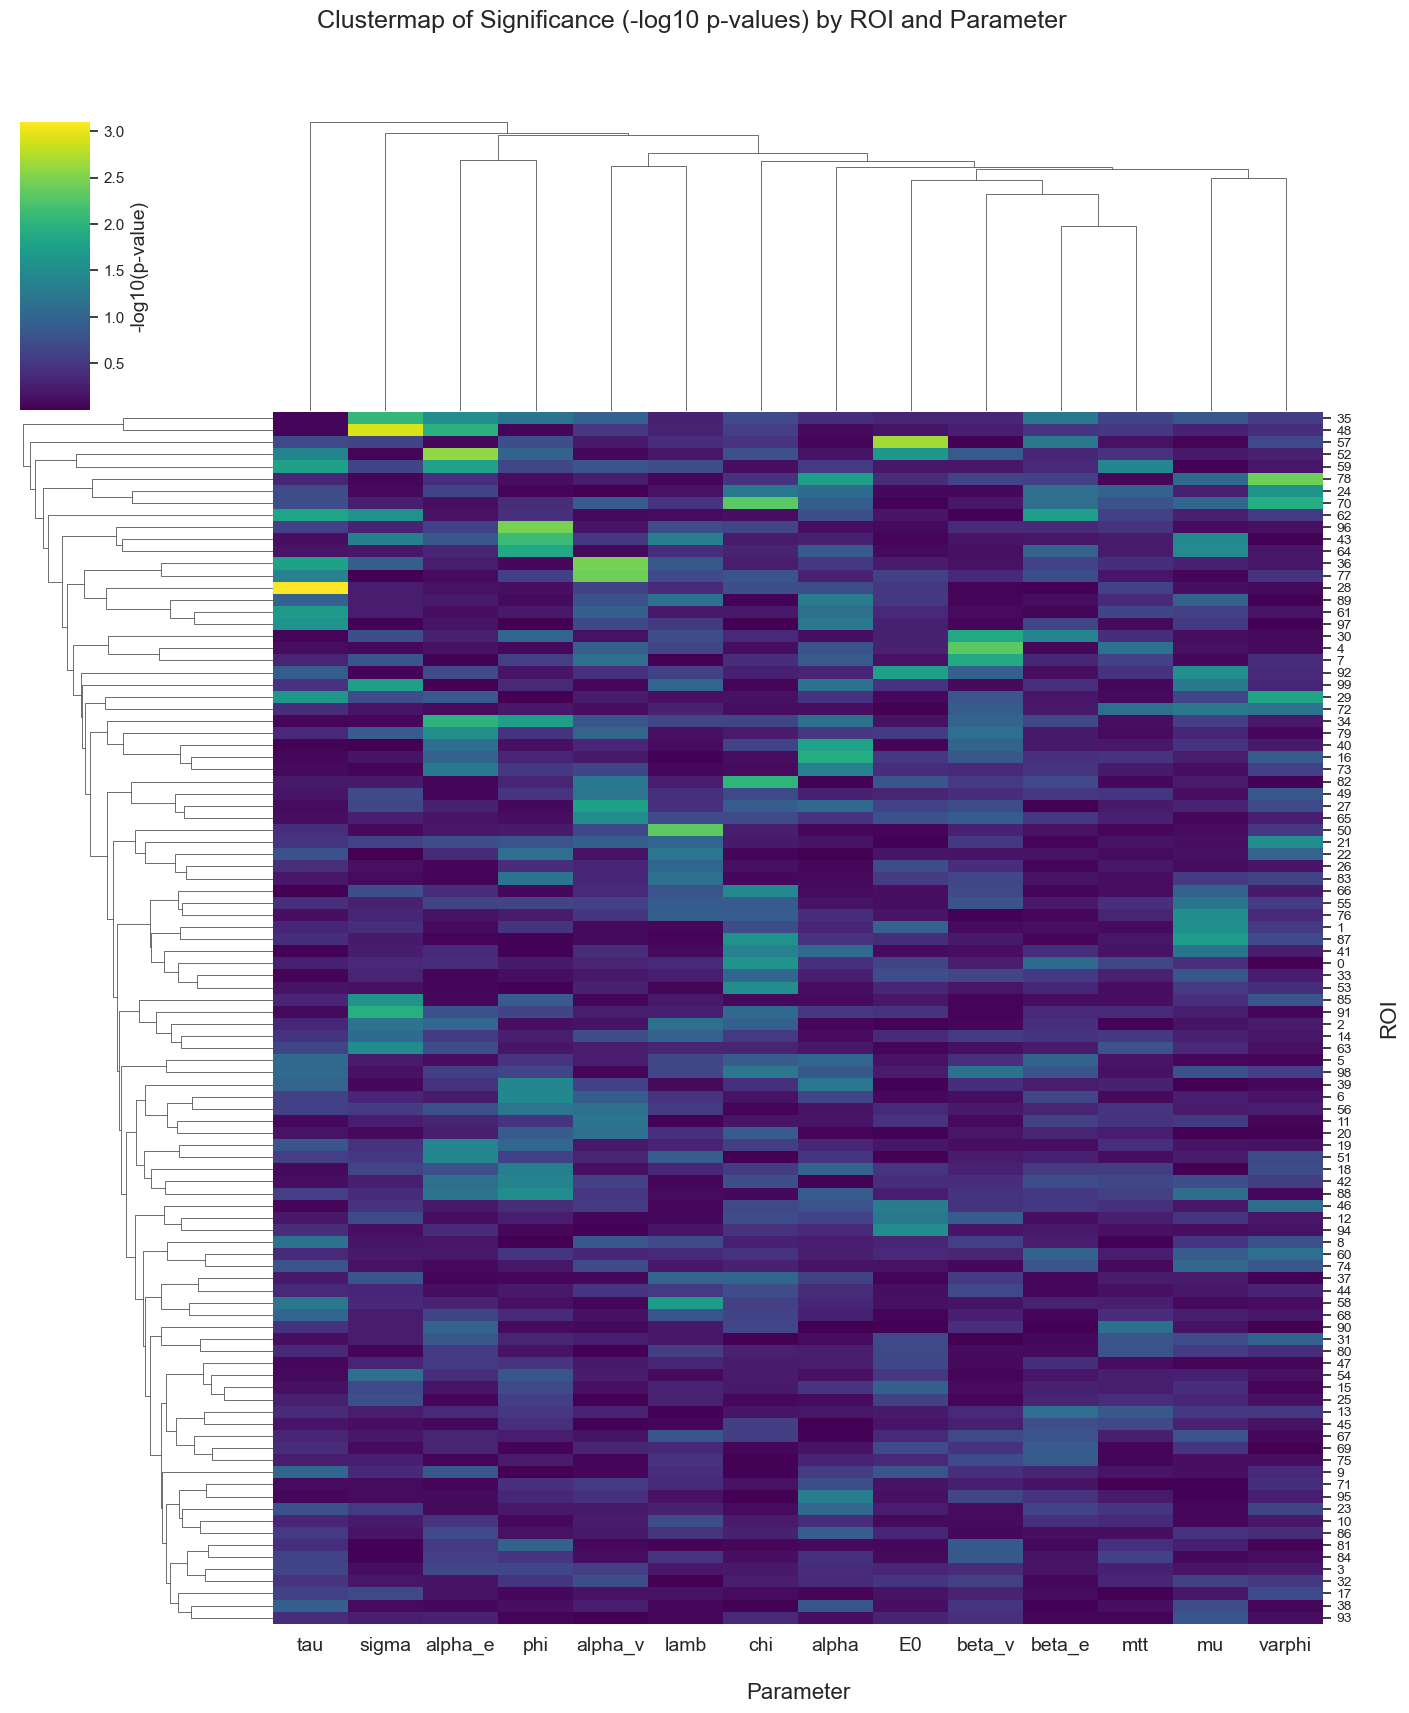

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the log-transformed p-values
pivot_pvals = roi_df.pivot(index="roi", columns="parameter", values="p_value")
log_pvals = -np.log10(pivot_pvals).sort_index().clip(upper=10)

g = sns.clustermap(
    log_pvals,
    cmap="viridis",
    figsize=(14, 16),
    yticklabels=True,
    annot=False,
    cbar_kws={"label": "-log10(p-value)"},
)

plt.suptitle(
    "Clustermap of Significance (-log10 p-values) by ROI and Parameter",
    y=1.05, fontsize=18
)

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=14)

plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)

g.cax.set_ylabel("-log10(p-value)", fontsize=14)


g.ax_heatmap.set_xlabel("Parameter", fontsize=16, labelpad=20)
g.ax_heatmap.set_ylabel("ROI", fontsize=16, labelpad=20)

plt.show()


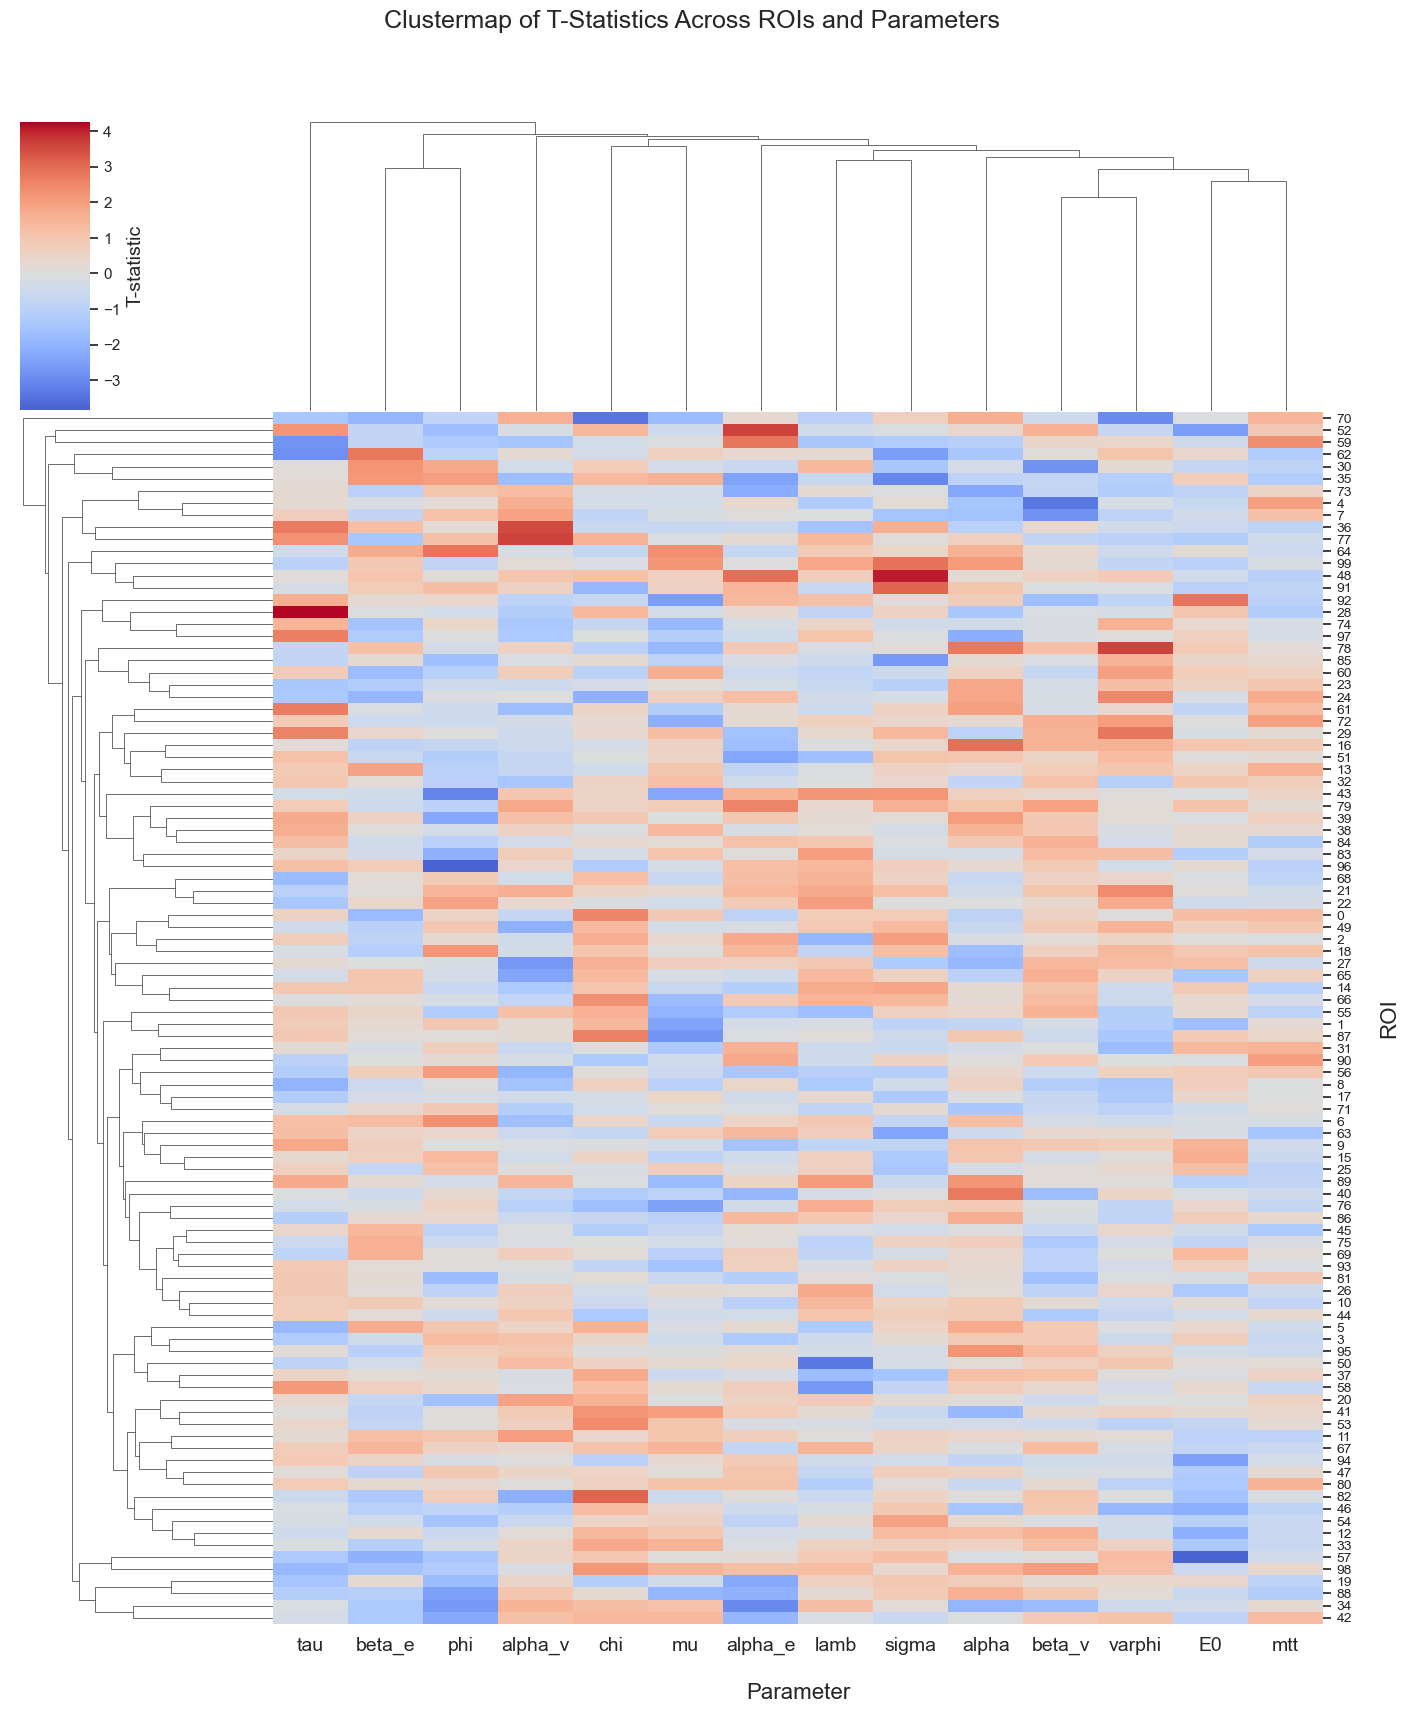

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
# Pivot the DataFrame for t-statistics
pivot_t = roi_df.pivot(index="roi", columns="parameter", values="t_stat")

# Create clustermap of t-statistics
h = sns.clustermap(
    pivot_t,
    cmap="coolwarm", center=0,
    figsize=(14, 16),
    yticklabels=True,
    annot=False
)

h.fig.suptitle("Clustermap of T-Statistics Across ROIs and Parameters", y=1.05, fontsize=18)
plt.setp(h.ax_heatmap.xaxis.get_majorticklabels(), fontsize=14)
plt.setp(h.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)
h.cax.set_ylabel("T-statistic", fontsize=14)
h.ax_heatmap.set_xlabel("Parameter", fontsize=16, labelpad=20)
h.ax_heatmap.set_ylabel("ROI", fontsize=16, labelpad=20)
plt.show()


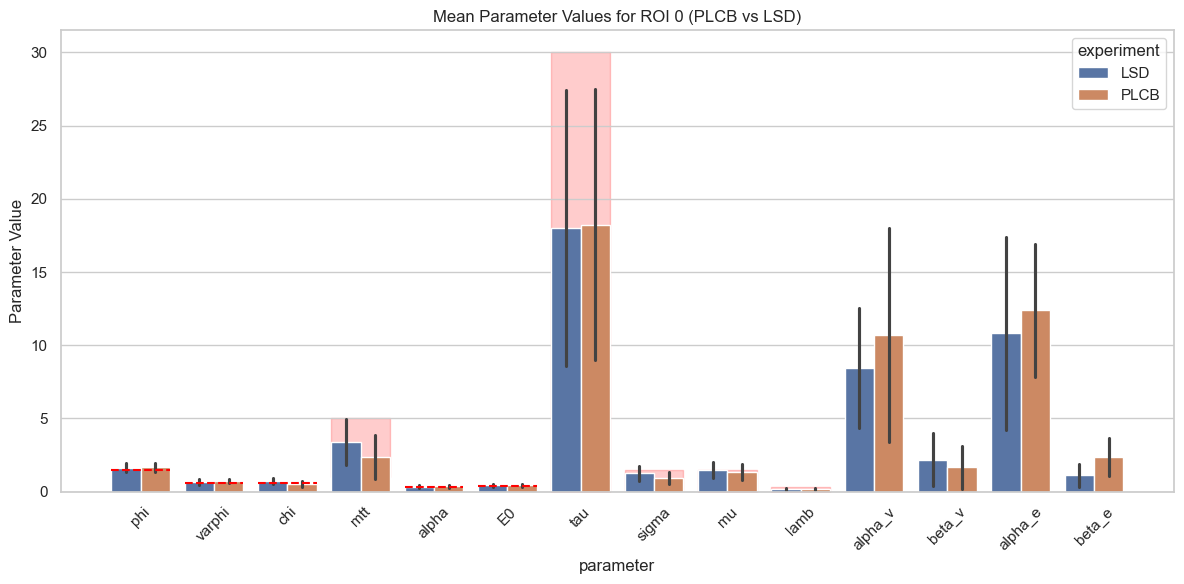

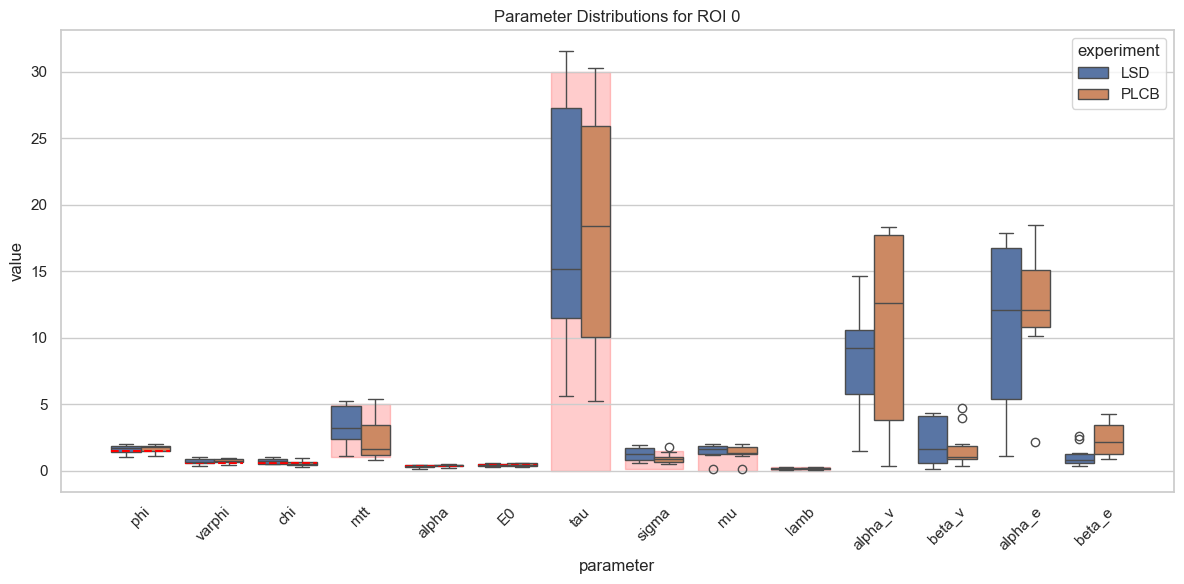

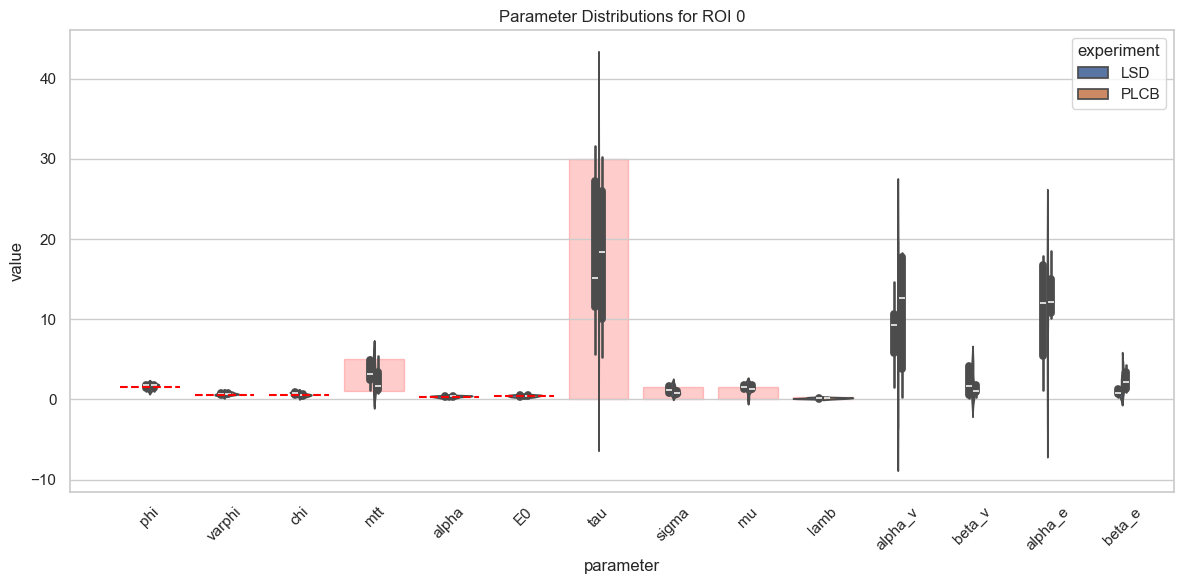

roi parameter  mean_diff   std_diff   cohen_d effect_size    t_stat  \
0     0        E0   0.055975   0.174770  0.320279       small  1.240434   
1     0     alpha  -0.041783   0.176561 -0.236652       small -0.916547   
2     0   alpha_e  -1.622821   7.065114 -0.229695       small -0.889605   
3     0   alpha_v  -1.547957   8.506191 -0.181980  very small -0.704806   
4     0    beta_e  -1.022832   2.179009 -0.469402       small -1.817987   
5     0    beta_v   0.279383   1.728850  0.161601  very small  0.625877   
6     0       chi   0.184047   0.284076  0.647880      medium  2.509229   
7     0      lamb   0.019199   0.096416  0.199129  very small  0.771222   
8     0       mtt   0.644134   1.952529  0.329897       small  1.277687   
9     0        mu   0.167738   0.723204  0.231938       small  0.898290   
10    0       phi   0.061967   0.460659  0.134519  very small  0.520989   
11    0     sigma   0.141101   0.692526  0.203748       small  0.789113   
12    0       tau   1.752344  10.811515  0.162081  very small  0.627738   
13    0    varphi   0.000702   0.266019  0.002638  very small  0.010217   

     p_value  reject_raw                         interpret_raw  p_fdr_bh  \
0   0.235202       False         not significant, ↑ LSD > PLCB  0.924457   
1   0.374899       False         not significant, ↓ LSD < PLCB  0.961221   
2   0.388709       False         not significant, ↓ LSD < PLCB  0.961221   
3   0.492491       False         not significant, ↓ LSD < PLCB  0.984144   
4   0.090523       False         not significant, ↓ LSD < PLCB  0.924457   
5   0.541466       False         not significant, ↑ LSD > PLCB  0.990445   
6   0.025016        True  marginally significant, ↑ LSD > PLCB  0.813854   
7   0.453396       False         not significant, ↑ LSD > PLCB  0.980916   
8   0.222141       False         not significant, ↑ LSD > PLCB  0.924457   
9   0.384220       False         not significant, ↑ LSD > PLCB  0.961221   
10  0.610517       False         not significant, ↑ LSD > PLCB  0.994110   
11  0.443205       False         not significant, ↑ LSD > PLCB  0.980916   
12  0.540280       False         not significant, ↑ LSD > PLCB  0.990445   
13  0.991993       False         not significant, ↑ LSD > PLCB  0.998433   

    reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0           False  not significant, ↑ LSD > PLCB           1.0   
1           False  not significant, ↓ LSD < PLCB           1.0   
2           False  not significant, ↓ LSD < PLCB           1.0   
3           False  not significant, ↓ LSD < PLCB           1.0   
4           False  not significant, ↓ LSD < PLCB           1.0   
5           False  not significant, ↑ LSD > PLCB           1.0   
6           False  not significant, ↑ LSD > PLCB           1.0   
7           False  not significant, ↑ LSD > PLCB           1.0   
8           False  not significant, ↑ LSD > PLCB           1.0   
9           False  not significant, ↑ LSD > PLCB           1.0   
10          False  not significant, ↑ LSD > PLCB           1.0   
11          False  not significant, ↑ LSD > PLCB           1.0   
12          False  not significant, ↑ LSD > PLCB           1.0   
13          False  not significant, ↑ LSD > PLCB           1.0   

    reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0               False  not significant, ↑ LSD > PLCB     1.0        False   
1               False  not significant, ↓ LSD < PLCB     1.0        False   
2               False  not significant, ↓ LSD < PLCB     1.0        False   
3               False  not significant, ↓ LSD < PLCB     1.0        False   
4               False  not significant, ↓ LSD < PLCB     1.0        False   
5               False  not significant, ↑ LSD > PLCB     1.0        False   
6               False  not significant, ↑ LSD > PLCB     1.0        False   
7               False  not significant, ↑ LSD > PLCB     1.0        False   
8               False  not significant, ↑ LSD > PLCB 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("pdcm_all_data.csv")

# Filter to only the parameters of interest
params = ['phi', 'varphi', 'chi', 'mtt', 'alpha', 'E0',
          'tau', 'sigma', 'mu', 'lamb',
          'alpha_v', 'beta_v', 'alpha_e', 'beta_e']

df = df[df["parameter"].isin(params)]

# Pivot so each parameter is a separate column
df_pivot = df.pivot_table(
    index=["subject", "roi", "experiment"],
    columns="parameter",
    values="value"
).reset_index()


literature_values = {
    'phi': 1.5,
    'varphi': 0.6,
    'chi': 0.6,
    'mtt': (1.0, 5.0),
    'tau': (0, 30),
    'sigma': (0.1, 1.5),
    'mu': (0, 1.5),
    'lamb': (0, 0.3),
    'alpha': 0.32,
    'E0': 0.4
}

chosen_roi = 0

# Filter for the chosen ROI
roi_data = df_pivot[df_pivot["roi"] == chosen_roi]

# Melt the data to long format for plotting
roi_melted = roi_data.melt(
    id_vars=["subject", "experiment"],
    value_vars=[col for col in roi_data.columns if col not in ["subject", "roi", "experiment"]],
    var_name="parameter",
    value_name="value"
)

selected_subjects = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]
selected_parameters = ['phi', 'varphi', 'chi', 'mtt', 'alpha', 'E0',
                       'tau', 'sigma', 'mu', 'lamb',
                       'alpha_v', 'beta_v', 'alpha_e', 'beta_e']

neurovascular_params = ['phi', 'varphi', 'chi', 'mtt', 'alpha', 'E0']
neuronal_params = ['sigma', 'mu', 'lamb']
noise_params = ['alpha_v', 'beta_v', 'alpha_e', 'beta_e', 'tau']

roi_melted = roi_melted[
    roi_melted["subject"].isin(selected_subjects) &
    roi_melted["parameter"].isin(selected_parameters)
    ]
roi_melted["parameter"] = pd.Categorical(
    roi_melted["parameter"],
    categories=selected_parameters,
    ordered=True
)


def add_literature_references(ax, parameters, bar_width=0.8):
    """
    Adds red lines or shaded areas only to the correct x-position for each parameter column.
    """
    xticks = ax.get_xticks()
    xlabels = [t.get_text() for t in ax.get_xticklabels()]
    param_to_x = dict(zip(xlabels, xticks))

    for param in parameters:
        if param not in literature_values or param not in param_to_x:
            continue

        x = param_to_x[param]
        half_width = bar_width / 2

        ref = literature_values[param]
        if isinstance(ref, tuple):
            ax.fill_between(
                [x - half_width, x + half_width],
                ref[0], ref[1],
                color='red', alpha=0.2, zorder=0
            )
        else:
            ax.plot(
                [x - half_width, x + half_width],
                [ref, ref],
                color='red', linestyle='--', linewidth=1.5
            )


#  Plot 1: Bar Plot 
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=roi_melted, x="parameter", y="value", hue="experiment", errorbar="sd")
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Mean Parameter Values for ROI {chosen_roi} (PLCB vs LSD)")
plt.ylabel("Parameter Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Plot 2: Box Plot 
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=roi_melted, x="parameter", y="value", hue="experiment")
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Parameter Distributions for ROI {chosen_roi}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Violin Plot 
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=roi_melted, x="parameter", y="value", hue="experiment", split=True)
add_literature_references(ax, roi_melted["parameter"].unique())
plt.title(f"Parameter Distributions for ROI {chosen_roi}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ttest_results = pd.read_csv("roi_ttest_results.csv")

# Filter for the chosen ROI
ttest_for_roi = ttest_results[ttest_results["roi"] == chosen_roi]

ttest_for_roi

In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")


df = pd.read_csv("pdcm_all_data.csv")

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau", "alpha", "E0", "sigma", "mu", "lamb", "alpha_v", "beta_v", "alpha_e", "beta_e"]

# Define networks and associated ROI indices
network_rois = {
    "All Regions": list(range(100)),
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 73)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 78)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 89)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

# Map ROIs to networks
roi_to_network = {}
for net, rois in network_rois.items():
    for roi in rois:
        roi_to_network[roi] = net

df["network"] = df["roi"].map(roi_to_network)

# Group and average per subject/network/condition
agg_df = df[df["parameter"].isin(params)].groupby(
    ["subject", "network", "experiment", "parameter"]
)["value"].mean().reset_index()

# Run one-sample t-tests per (network, parameter)
results = []

from scipy.stats import ttest_rel

results = []

for net in agg_df["network"].unique():
    for param in params:
        # Get data for PLCB and LSD
        lsd_vals = agg_df[(agg_df["network"] == net) & (agg_df["parameter"] == param) & (agg_df["experiment"] == "LSD")]
        plcb_vals = agg_df[(agg_df["network"] == net) & (agg_df["parameter"] == param) & (agg_df["experiment"] == "PLCB")]

        # Merge on subject to ensure matched pairs
        merged = pd.merge(lsd_vals, plcb_vals, on="subject", suffixes=("_LSD", "_PLCB"))

        if len(merged) < 3:
            continue

        diff = merged["value_LSD"] - merged["value_PLCB"]
        t_stat, p_val = ttest_rel(merged["value_LSD"], merged["value_PLCB"])
        mean_diff = diff.mean()
        std_diff = diff.std(ddof=1)
        cohen_d = mean_diff / std_diff if std_diff != 0 else np.nan

        results.append({
            "network": net,
            "parameter": param,
            "mean_diff": mean_diff,
            "std_diff": std_diff,
            "cohen_d": cohen_d,
            "t_stat": t_stat,
            "p_value": p_val
        })



results_df = pd.DataFrame(results)

# Apply FDR, Bonferroni, Holm
pvals = results_df["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

# Add to DataFrame
results_df["p_fdr_bh"] = p_fdr
results_df["reject_fdr_bh"] = rej_fdr
results_df["p_bonferroni"] = p_bonf
results_df["reject_bonferroni"] = rej_bonf
results_df["p_holm"] = p_holm
results_df["reject_holm"] = rej_holm
results_df["reject_raw"] = results_df["p_value"] < 0.05

def interpret_delta(p, mean):
    direction = "↑ LSD > PLCB" if mean > 0 else "↓ LSD < PLCB"
    if p < 0.001:
        return f"highly significant, {direction}"
    elif p < 0.01:
        return f"significant, {direction}"
    elif p < 0.05:
        return f"marginally significant, {direction}"
    else:
        return f"not significant, {direction}"


def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"

# Add interpretation based on mean_diff
results_df["interpret_raw"] = results_df.apply(lambda row: interpret_delta(row["p_value"], row["mean_diff"]), axis=1)
results_df["interpret_fdr_bh"] = results_df.apply(lambda row: interpret_delta(row["p_fdr_bh"], row["mean_diff"]), axis=1)
results_df["interpret_bonferroni"] = results_df.apply(lambda row: interpret_delta(row["p_bonferroni"], row["mean_diff"]), axis=1)
results_df["interpret_holm"] = results_df.apply(lambda row: interpret_delta(row["p_holm"], row["mean_diff"]), axis=1)


results_df = results_df[[
    "network", "parameter", "mean_diff", "std_diff", "cohen_d", "t_stat",
    "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]


results_df.sort_values("network", inplace=True)
results_df


network parameter  mean_diff  std_diff   cohen_d    t_stat   p_value  \
0    LH Control       phi  -0.016271  0.248961 -0.065355 -0.253120  0.803855   
13   LH Control    beta_e   0.066973  0.862778  0.077625  0.300641  0.768107   
12   LH Control   alpha_e  -2.430111  3.186693 -0.762581 -2.953462  0.010474   
11   LH Control    beta_v   0.102859  1.105013  0.093084  0.360514  0.723844   
10   LH Control   alpha_v   1.859207  4.057743  0.458187  1.774552  0.097710   
..          ...       ...        ...       ...       ...       ...       ...   
183   RH Visual    varphi   0.020018  0.128186  0.156164  0.604821  0.554975   
182   RH Visual       phi  -0.061174  0.130259 -0.469630 -1.818868  0.090382   
194   RH Visual   alpha_e  -0.547232  2.779070 -0.196912 -0.762636  0.458338   
187   RH Visual     alpha   0.008015  0.050897  0.157466  0.609862  0.551724   
195   RH Visual    beta_e  -0.197678  0.731137 -0.270371 -1.047143  0.312776   

     reject_raw                         interpret_raw  p_fdr_bh  \
0         False         not significant, ↓ LSD < PLCB  0.939169   
13        False         not significant, ↑ LSD > PLCB  0.939169   
12         True  marginally significant, ↓ LSD < PLCB  0.568909   
11        False         not significant, ↑ LSD > PLCB  0.937338   
10        False         not significant, ↑ LSD > PLCB  0.593801   
..          ...                                   ...       ...   
183       False         not significant, ↑ LSD > PLCB  0.929337   
182       False         not significant, ↓ LSD < PLCB  0.593801   
194       False         not significant, ↓ LSD < PLCB  0.898343   
187       False         not significant, ↑ LSD > PLCB  0.929337   
195       False         not significant, ↓ LSD < PLCB  0.791000   

     reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0            False  not significant, ↓ LSD < PLCB           1.0   
13           False  not significant, ↑ LSD > PLCB           1.0   
12           False  not significant, ↓ LSD < PLCB           1.0   
11           False  not significant, ↑ LSD > PLCB           1.0   
10           False  not significant, ↑ LSD > PLCB           1.0   
..             ...                            ...           ...   
183          False  not significant, ↑ LSD > PLCB           1.0   
182          False  not significant, ↓ LSD < PLCB           1.0   
194          False  not significant, ↓ LSD < PLCB           1.0   
187          False  not significant, ↑ LSD > PLCB           1.0   
195          False  not significant, ↓ LSD < PLCB           1.0   

     reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0                False  not significant, ↓ LSD < PLCB     1.0        False   
13               False  not significant, ↑ LSD > PLCB     1.0        False   
12               False  not significant, ↓ LSD < PLCB     1.0        False   
11               False  not significant, ↑ LSD > PLCB     1.0        False   
10               False  not significant, ↑ LSD > PLCB     1.0        False   
..                 ...                            ...     ...          ...   
183              False  not significant, ↑ LSD > PLCB     1.0        False   
182              False  not significant, ↓ LSD < PLCB     1.0        False   
194              False  not significant, ↓ LSD < PLCB     1.0        False   
187              False  not significant, ↑ LSD > PLCB     1.0        False   
195              False  not significant, ↓ LSD < PLCB     1.0        False   

                    interpret_holm  
0    not significant, ↓ LSD < PLCB  
13   not significant, ↑ LSD > PLCB  
12   not significant, ↓ LSD < PLCB  
11   not significant, ↑ LSD > PLCB  
10   not significant, ↑ LSD > PLCB  
..                             ...  
183  not significant, ↑ LSD > PLCB  
182  not significant, ↓ LSD < PLCB  
194  not significant, ↓ LSD < PLCB  
187  not significant, ↑ LSD > PLCB  
195  not significant, ↓ LSD < PLCB  

[196 rows x 18 columns]

In [59]:
# Filter rows where raw p-value is significant
sig = results_df[results_df["p_value"] <= 0.05].copy()

sig.sort_values("network", ascending=False, inplace=True)

sig

network parameter  mean_diff  std_diff   cohen_d  \
188                      RH Visual        E0  -0.032556  0.058360 -0.557856   
184                      RH Visual       chi   0.078881  0.111734  0.705966   
178                 RH Somatomotor   alpha_v  -1.281468  2.298204 -0.557595   
152                      RH Limbic   alpha_e   3.320994  4.115335  0.806980   
124                RH Default Mode   alpha_e   1.734093  2.349911  0.737940   
117                RH Default Mode     alpha   0.028426  0.028117  1.010963   
84                       LH Visual       phi   0.091158  0.123855  0.736004   
57   LH Salience/Ventral Attention    varphi   0.091189  0.118264  0.771060   
29             LH Dorsal Attention    varphi   0.065031  0.105200  0.618171   
16                 LH Default Mode       chi   0.051507  0.088349  0.582993   
12                      LH Control   alpha_e  -2.430111  3.186693 -0.762581   
2                       LH Control       chi   0.073587  0.123205  0.597271   

       t_stat   p_value  reject_raw                         interpret_raw  \
188 -2.160567  0.048551        True  marginally significant, ↓ LSD < PLCB   
184  2.734196  0.016138        True  marginally significant, ↑ LSD > PLCB   
178 -2.159558  0.048643        True  marginally significant, ↓ LSD < PLCB   
152  2.795461  0.017416        True  marginally significant, ↑ LSD > PLCB   
124  2.447470  0.034406        True  marginally significant, ↑ LSD > PLCB   
117  3.352985  0.007328        True             significant, ↑ LSD > PLCB   
84   2.850531  0.012836        True  marginally significant, ↑ LSD > PLCB   
57   2.986304  0.009814        True             significant, ↑ LSD > PLCB   
29   2.394166  0.031216        True  marginally significant, ↑ LSD > PLCB   
16   2.257922  0.040445        True  marginally significant, ↑ LSD > PLCB   
12  -2.953462  0.010474        True  marginally significant, ↓ LSD < PLCB   
2    2.313222  0.036425        True  marginally significant, ↑ LSD > PLCB   

     p_fdr_bh  reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
188  0.593801          False  not significant, ↓ LSD < PLCB           1.0   
184  0.568909          False  not significant, ↑ LSD > PLCB           1.0   
178  0.593801          False  not significant, ↓ LSD < PLCB           1.0   
152  0.568909          False  not significant, ↑ LSD > PLCB           1.0   
124  0.593801          False  not significant, ↑ LSD > PLCB           1.0   
117  0.568909          False  not significant, ↑ LSD > PLCB           1.0   
84   0.568909          False  not significant, ↑ LSD > PLCB           1.0   
57   0.568909          False  not significant, ↑ LSD > PLCB           1.0   
29   0.593801          False  not significant, ↑ LSD > PLCB           1.0   
16   0.593801          False  not significant, ↑ LSD > PLCB           1.0   
12   0.568909          False  not significant, ↓ LSD < PLCB           1.0   
2    0.593801          False  not significant, ↑ LSD > PLCB           1.0   

     reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
188              False  not significant, ↓ LSD < PLCB     1.0        False   
184              False  not significant, ↑ LSD > PLCB     1.0        False   
178              False  not significant, ↓ LSD < PLCB     1.0        False   
152              False  not significant, ↑ LSD > PLCB     1.0        False   
124              False  not significant, ↑ LSD > PLCB     1.0        False   
117              False  not significant, ↑ LSD > PLCB     1.0        False   
84               False  not significant, ↑ LSD > PLCB     1.0        False   
57               False  not significant, ↑ LSD > PLCB     1.0        False   
29               False  not significant, ↑ LSD > PLCB     1.0        False   
16               False  not significant, ↑ LSD > PLCB     1.0        False   
12               False  not significant, ↓ LSD < PLCB     1.0        False   
2                False  not significant, ↑ LSD > PLCB     1

In [60]:
# Bonferroni 
sig_bonf = results_df[results_df["reject_bonferroni"] == True]
sig_bonf

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [61]:
# FDR BH significant
sig_fdr = results_df[results_df["reject_fdr_bh"] == True]
sig_fdr

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [62]:
# Holm significant
sig_holm = results_df[results_df["reject_holm"] == True]
sig_holm

Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [63]:
# Filter where the tests show significant difference
consistently_sig = results_df[
    (results_df["reject_raw"] == True) &
    (results_df["reject_fdr_bh"] == True) &
    (results_df["reject_bonferroni"] == True) &
    (results_df["reject_holm"] == True)
]


consistently_sig = consistently_sig.sort_values("network")


consistently_sig


Empty DataFrame
Columns: [network, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_41531/2219225149.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data[pval_pivot >= 0.05] = ""  # blank where p is not significant
/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_41531/2219225149.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")


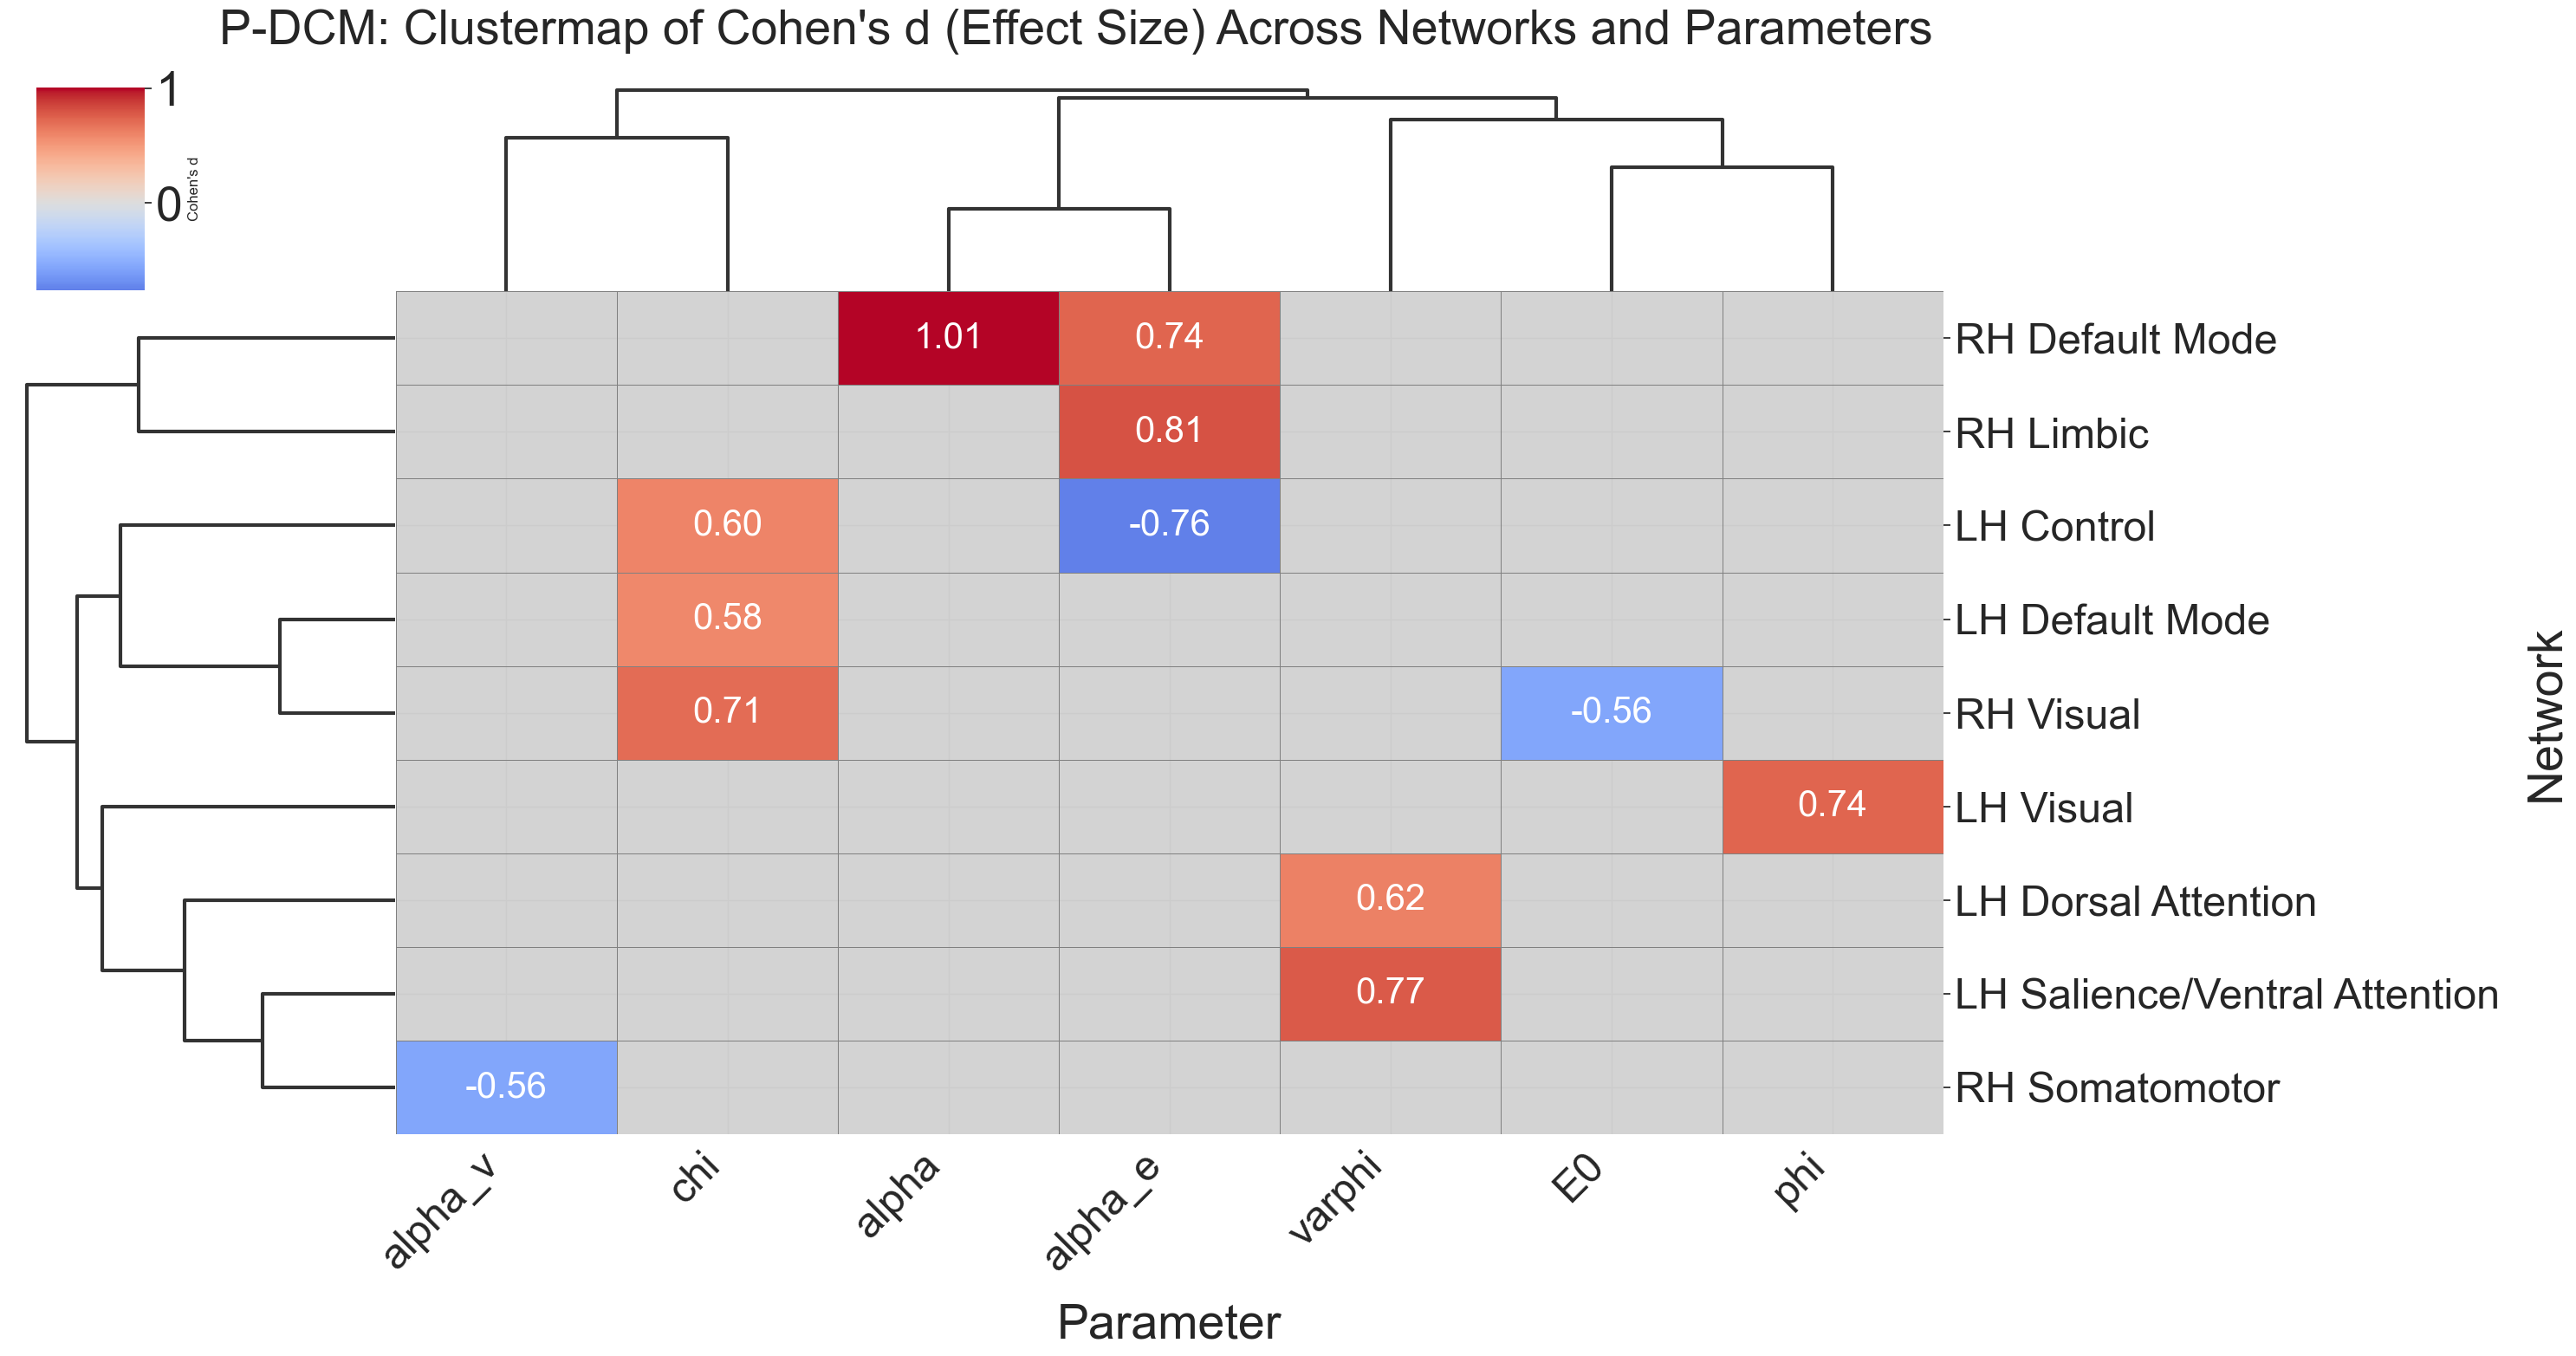


Significant Cohen's d (p < 0.05):
                      network parameter   cohen_d  p_value
              RH Default Mode     alpha  1.010963 0.007328
LH Salience/Ventral Attention    varphi  0.771060 0.009814
                   LH Control   alpha_e -0.762581 0.010474
                    LH Visual       phi  0.736004 0.012836
                    RH Visual       chi  0.705966 0.016138
                    RH Limbic   alpha_e  0.806980 0.017416
          LH Dorsal Attention    varphi  0.618171 0.031216
              RH Default Mode   alpha_e  0.737940 0.034406
                   LH Control       chi  0.597271 0.036425
              LH Default Mode       chi  0.582993 0.040445
                    RH Visual        E0 -0.557856 0.048551
               RH Somatomotor   alpha_v -0.557595 0.048643

Row Dendrogram Linkage (Networks):
   Cluster 1  Cluster 2  Distance  Sample Count
0        1.0        8.0  0.527944           2.0
1        3.0        7.0  0.608277           2.0
2        2.0      

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.collections import LineCollection

# Pivot Cohen's d values
net_pivot_d = results_df.pivot(index="network", columns="parameter", values="cohen_d")

# Rename parameters for consistency
rename_map = {"lamb": "lambda", "mtt": "tau", "tau": "tau_1"}
net_pivot_d.rename(columns=rename_map, inplace=True)

# Pivot p-values for significance masking
pval_pivot = results_df.pivot(index="network", columns="parameter", values="p_value")
pval_pivot.rename(columns=rename_map, inplace=True)

# Create annotation DataFrame: only show Cohen's d where p < 0.05
annot_data = net_pivot_d.copy()
annot_data[pval_pivot >= 0.05] = ""  # blank where p is not significant
annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")
mask = pval_pivot >= 0.05

# Identify rows with at least one significant p-value
significant_rows = (pval_pivot < 0.05).any(axis=1)

# Filter pivoted data and annotations
net_pivot_d = net_pivot_d.loc[significant_rows]
pval_pivot = pval_pivot.loc[significant_rows]
annot_data = annot_data.loc[significant_rows]
mask = mask.loc[significant_rows]

# Identify rows with at least one significant p-value
significant_rows = (pval_pivot < 0.05).any(axis=1)

# NEW: Identify columns (parameters) with at least one significant p-value
significant_cols = (pval_pivot < 0.05).any(axis=0)

# Filter pivoted data and annotations for significant rows AND columns
net_pivot_d = net_pivot_d.loc[significant_rows, significant_cols]
pval_pivot = pval_pivot.loc[significant_rows, significant_cols]
annot_data = annot_data.loc[significant_rows, significant_cols]
mask = mask.loc[significant_rows, significant_cols]

h_net = sns.clustermap(
    net_pivot_d,
    cmap="coolwarm",
    center=0,
    figsize=(25, 13),
    yticklabels=True,
    xticklabels=True,
    annot=annot_data,
    fmt="",
    annot_kws={"size": 30},
    cbar_kws={"label": "Cohen's d"},
    mask=mask,
    linewidths=0.5,  
    linecolor="gray"  
)

h_net.ax_heatmap.set_facecolor("lightgray")
for ax in [h_net.ax_col_dendrogram, h_net.ax_row_dendrogram]:
    for collection in ax.collections:
        if isinstance(collection, LineCollection):
            collection.set_linewidth(3.0)

h_net.fig.suptitle("P-DCM: Clustermap of Cohen's d (Effect Size) Across Networks and Parameters",
                   y=1.05, fontsize=40)
h_net.ax_heatmap.set_xlabel("Parameter", fontsize=40, labelpad=20)
h_net.ax_heatmap.set_ylabel("Network", fontsize=40, labelpad=20)

plt.setp(h_net.ax_heatmap.xaxis.get_majorticklabels(), fontsize=35, rotation=45, ha="right")
plt.setp(h_net.ax_heatmap.yaxis.get_majorticklabels(), fontsize=35)
h_net.cax.tick_params(labelsize=40)

plt.show()

sig_cohen_d = results_df[results_df["p_value"] < 0.05].copy()
sig_cohen_d["parameter"] = sig_cohen_d["parameter"].replace(rename_map)
sig_cohen_d = sig_cohen_d[["network", "parameter", "cohen_d", "p_value"]].sort_values(by="p_value")

print("\nSignificant Cohen's d (p < 0.05):")
print(sig_cohen_d.to_string(index=False))

row_linkage_df = pd.DataFrame(h_net.dendrogram_row.linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
col_linkage_df = pd.DataFrame(h_net.dendrogram_col.linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])

print("\nRow Dendrogram Linkage (Networks):")
print(row_linkage_df)

print("\nColumn Dendrogram Linkage (Parameters):")
print(col_linkage_df)


/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_41531/41926454.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")
/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_41531/41926454.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")


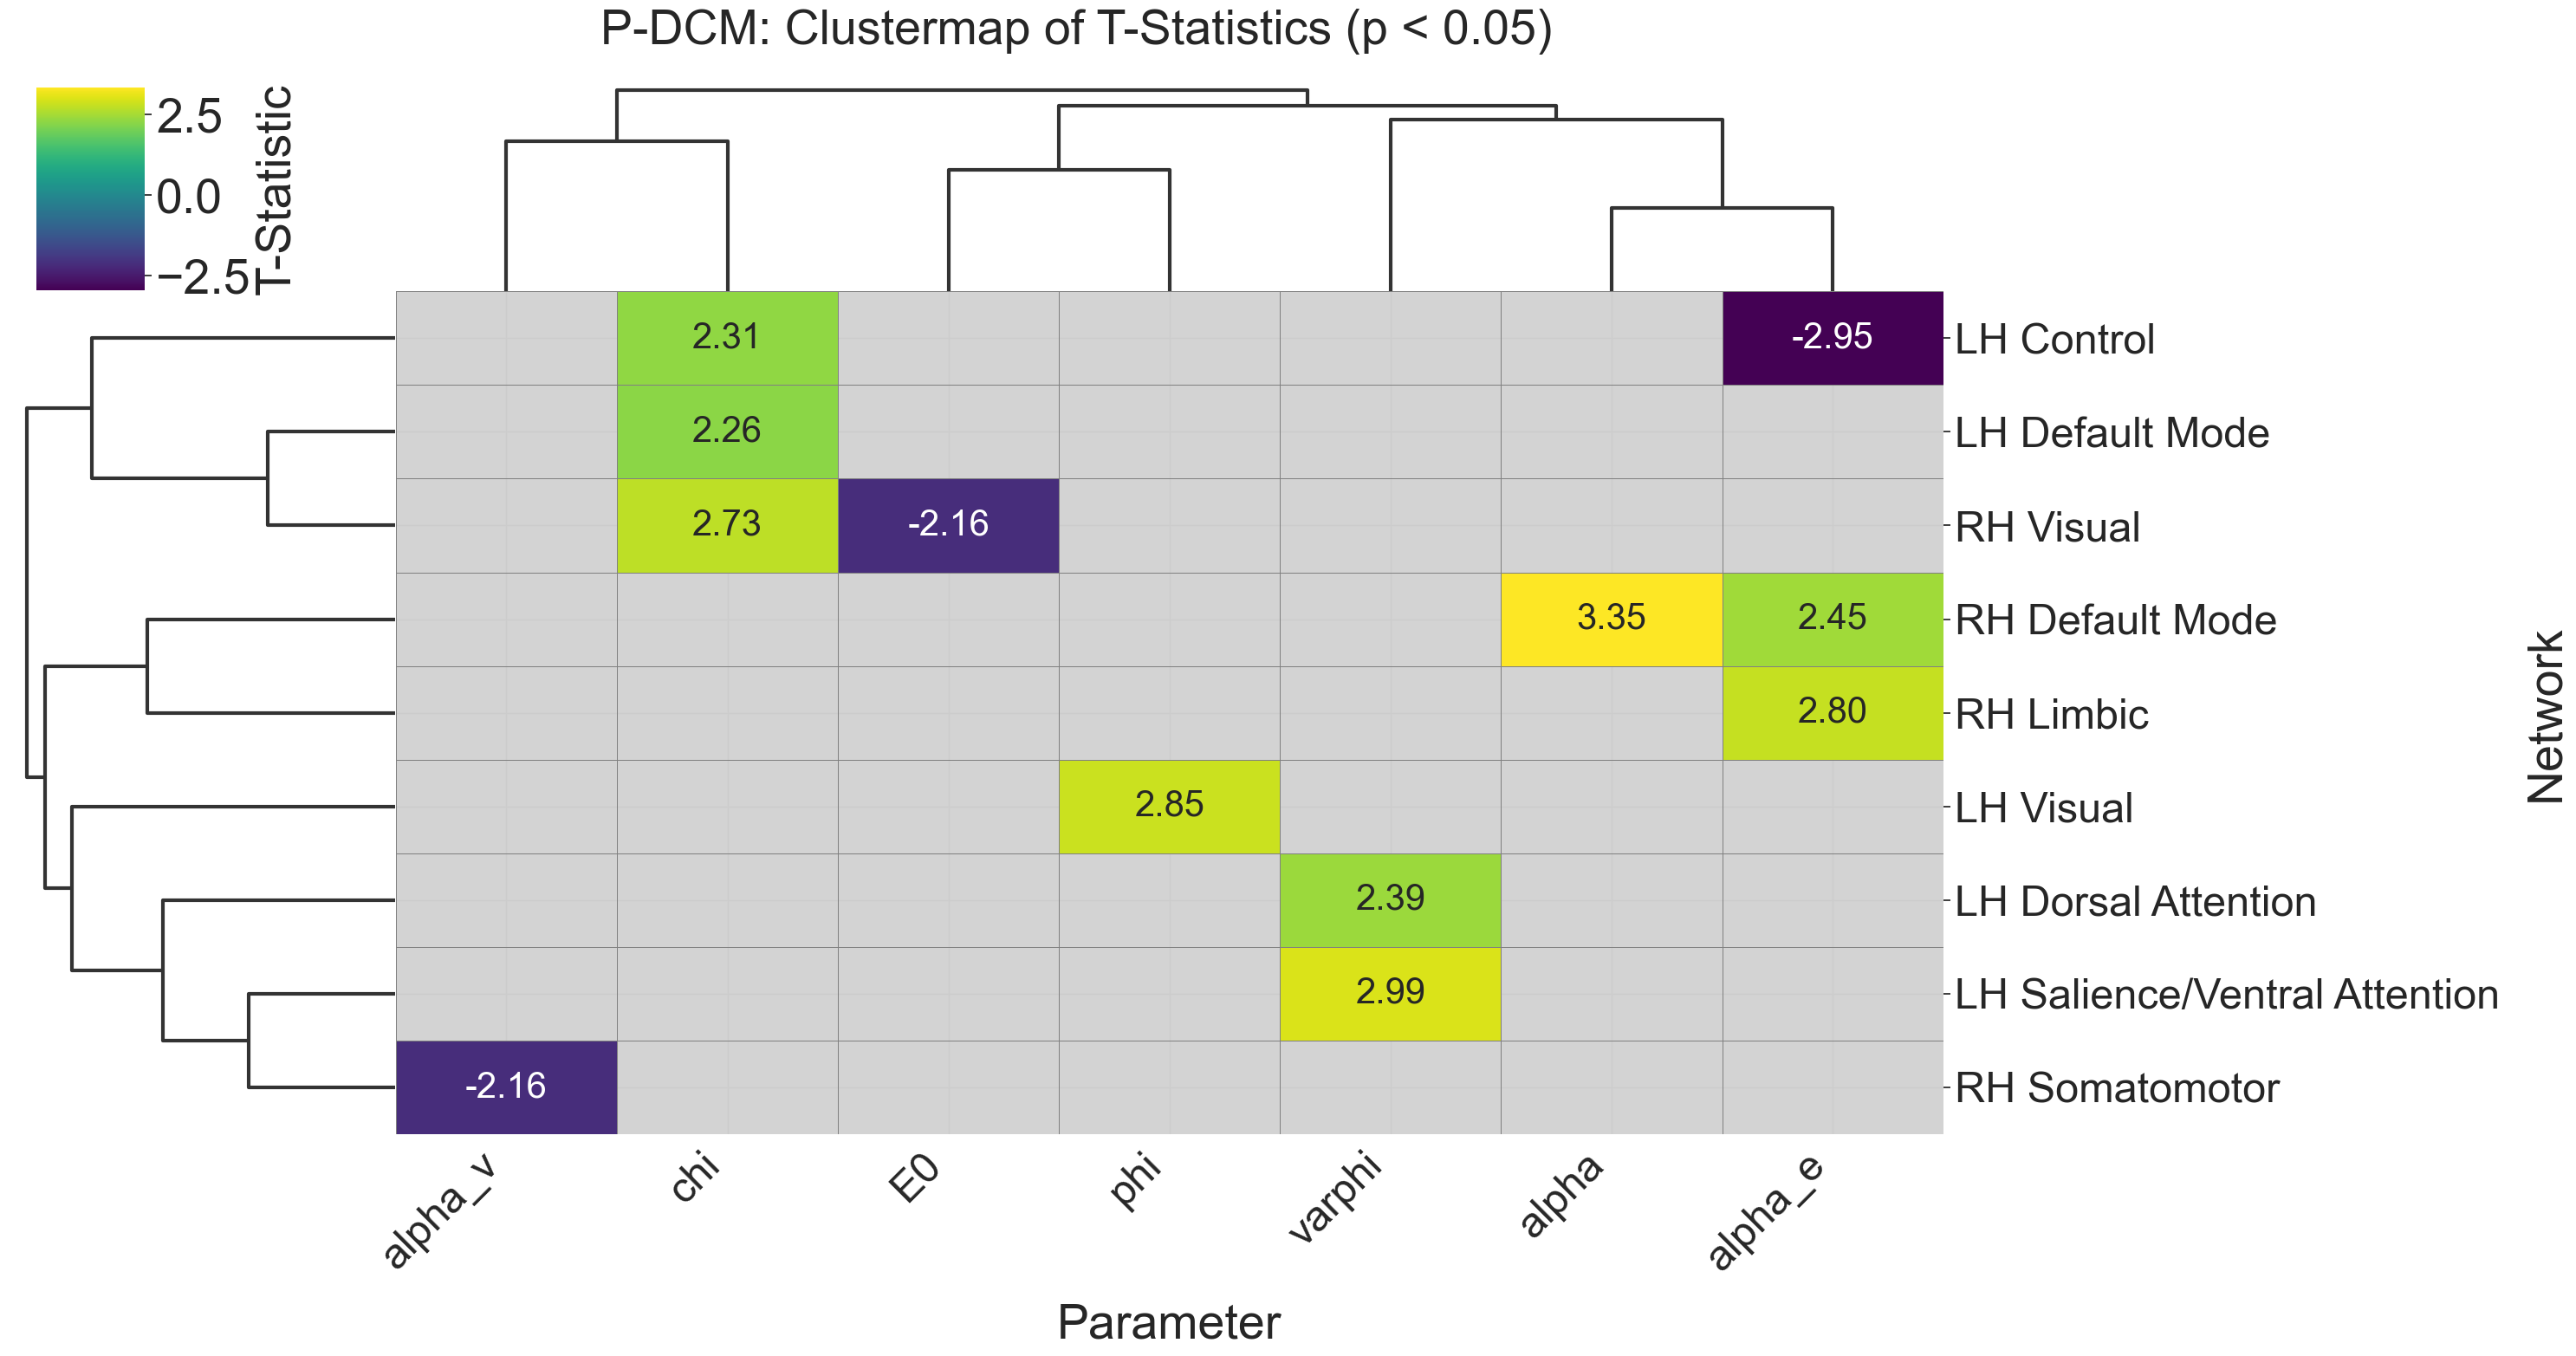


Significant T-Statistics (p < 0.05):
                      network parameter    t_stat  p_value
              RH Default Mode     alpha  3.352985 0.007328
LH Salience/Ventral Attention    varphi  2.986304 0.009814
                   LH Control   alpha_e -2.953462 0.010474
                    LH Visual       phi  2.850531 0.012836
                    RH Visual       chi  2.734196 0.016138
                    RH Limbic   alpha_e  2.795461 0.017416
          LH Dorsal Attention    varphi  2.394166 0.031216
              RH Default Mode   alpha_e  2.447470 0.034406
                   LH Control       chi  2.313222 0.036425
              LH Default Mode       chi  2.257922 0.040445
                    RH Visual        E0 -2.160567 0.048551
               RH Somatomotor   alpha_v -2.159558 0.048643

Row Dendrogram Linkage (Networks):
   Cluster 1  Cluster 2  Distance  Sample Count
0        1.0        8.0  2.044717           2.0
1        3.0        7.0  2.355847           2.0
2        2.0   

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import LineCollection

# Filter only significant entries
sig_df = results_df[results_df["p_value"] < 0.05].copy()

# Rename parameters for clarity
rename_map = {"lamb": "lambda", "mtt": "tau", "tau": "tau_1"}
sig_df["parameter"] = sig_df["parameter"].replace(rename_map)


# Pivot full matrix, even including non-significant values
full_df = results_df.copy()
full_df["parameter"] = full_df["parameter"].replace(rename_map)
net_pivot_d = full_df.pivot(index="network", columns="parameter", values="t_stat")

# Create mask for non-significant values
mask = full_df.pivot(index="network", columns="parameter", values="p_value") >= 0.05

# Create annotation: show t-stat only for significant entries
annot_data = net_pivot_d.copy()
annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")

# Drop rows (networks) with no significant values
sig_networks = mask.index[~mask.all(axis=1)]
net_pivot_d = net_pivot_d.loc[sig_networks]
mask = mask.loc[sig_networks]
annot_data = annot_data.loc[sig_networks]

# Drop columns (parameters) with no significant values across remaining networks
sig_parameters = mask.columns[~mask.all(axis=0)]
net_pivot_d = net_pivot_d[sig_parameters]
mask = mask[sig_parameters]
annot_data = annot_data[sig_parameters]

# Create annotation: show t-stat only for significant entries
annot_data = net_pivot_d.where(~mask, "")
annot_data = annot_data.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else "")

h_net = sns.clustermap(
    net_pivot_d,
    cmap="viridis",
    figsize=(25, 13),
    yticklabels=True,
    xticklabels=True,
    annot=annot_data,
    mask = mask,
    fmt="",
    annot_kws={"size": 30},
    cbar_kws={"label": "T-statistic"},
    linewidths=0.5,  
    linecolor="gray"  
)
h_net.ax_heatmap.set_facecolor("lightgray")

for ax in [h_net.ax_col_dendrogram, h_net.ax_row_dendrogram]:
    for collection in ax.collections:
        if isinstance(collection, LineCollection):
            collection.set_linewidth(3.0)

h_net.fig.suptitle("P-DCM: Clustermap of T-Statistics (p < 0.05)", y=1.05, fontsize=40)
h_net.ax_heatmap.set_xlabel("Parameter", fontsize=40, labelpad=20)
h_net.ax_heatmap.set_ylabel("Network", fontsize=40, labelpad=20)

plt.setp(h_net.ax_heatmap.xaxis.get_majorticklabels(), fontsize=35, rotation=45, ha="right")
plt.setp(h_net.ax_heatmap.yaxis.get_majorticklabels(), fontsize=35)
h_net.cax.set_ylabel("T-Statistic", fontsize=40)
h_net.cax.tick_params(labelsize=40)

plt.show()
sig_t_stats = sig_df[["network", "parameter", "t_stat", "p_value"]].sort_values(by="p_value")

print("\nSignificant T-Statistics (p < 0.05):")
print(sig_t_stats.to_string(index=False))


row_linkage_df = pd.DataFrame(h_net.dendrogram_row.linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
col_linkage_df = pd.DataFrame(h_net.dendrogram_col.linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])

print("\nRow Dendrogram Linkage (Networks):")
print(row_linkage_df)

print("\nColumn Dendrogram Linkage (Parameters):")
print(col_linkage_df)


/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_41531/800428267.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = annot_data.applymap(lambda x: f"{x:.1f}" if isinstance(x, float) else "")


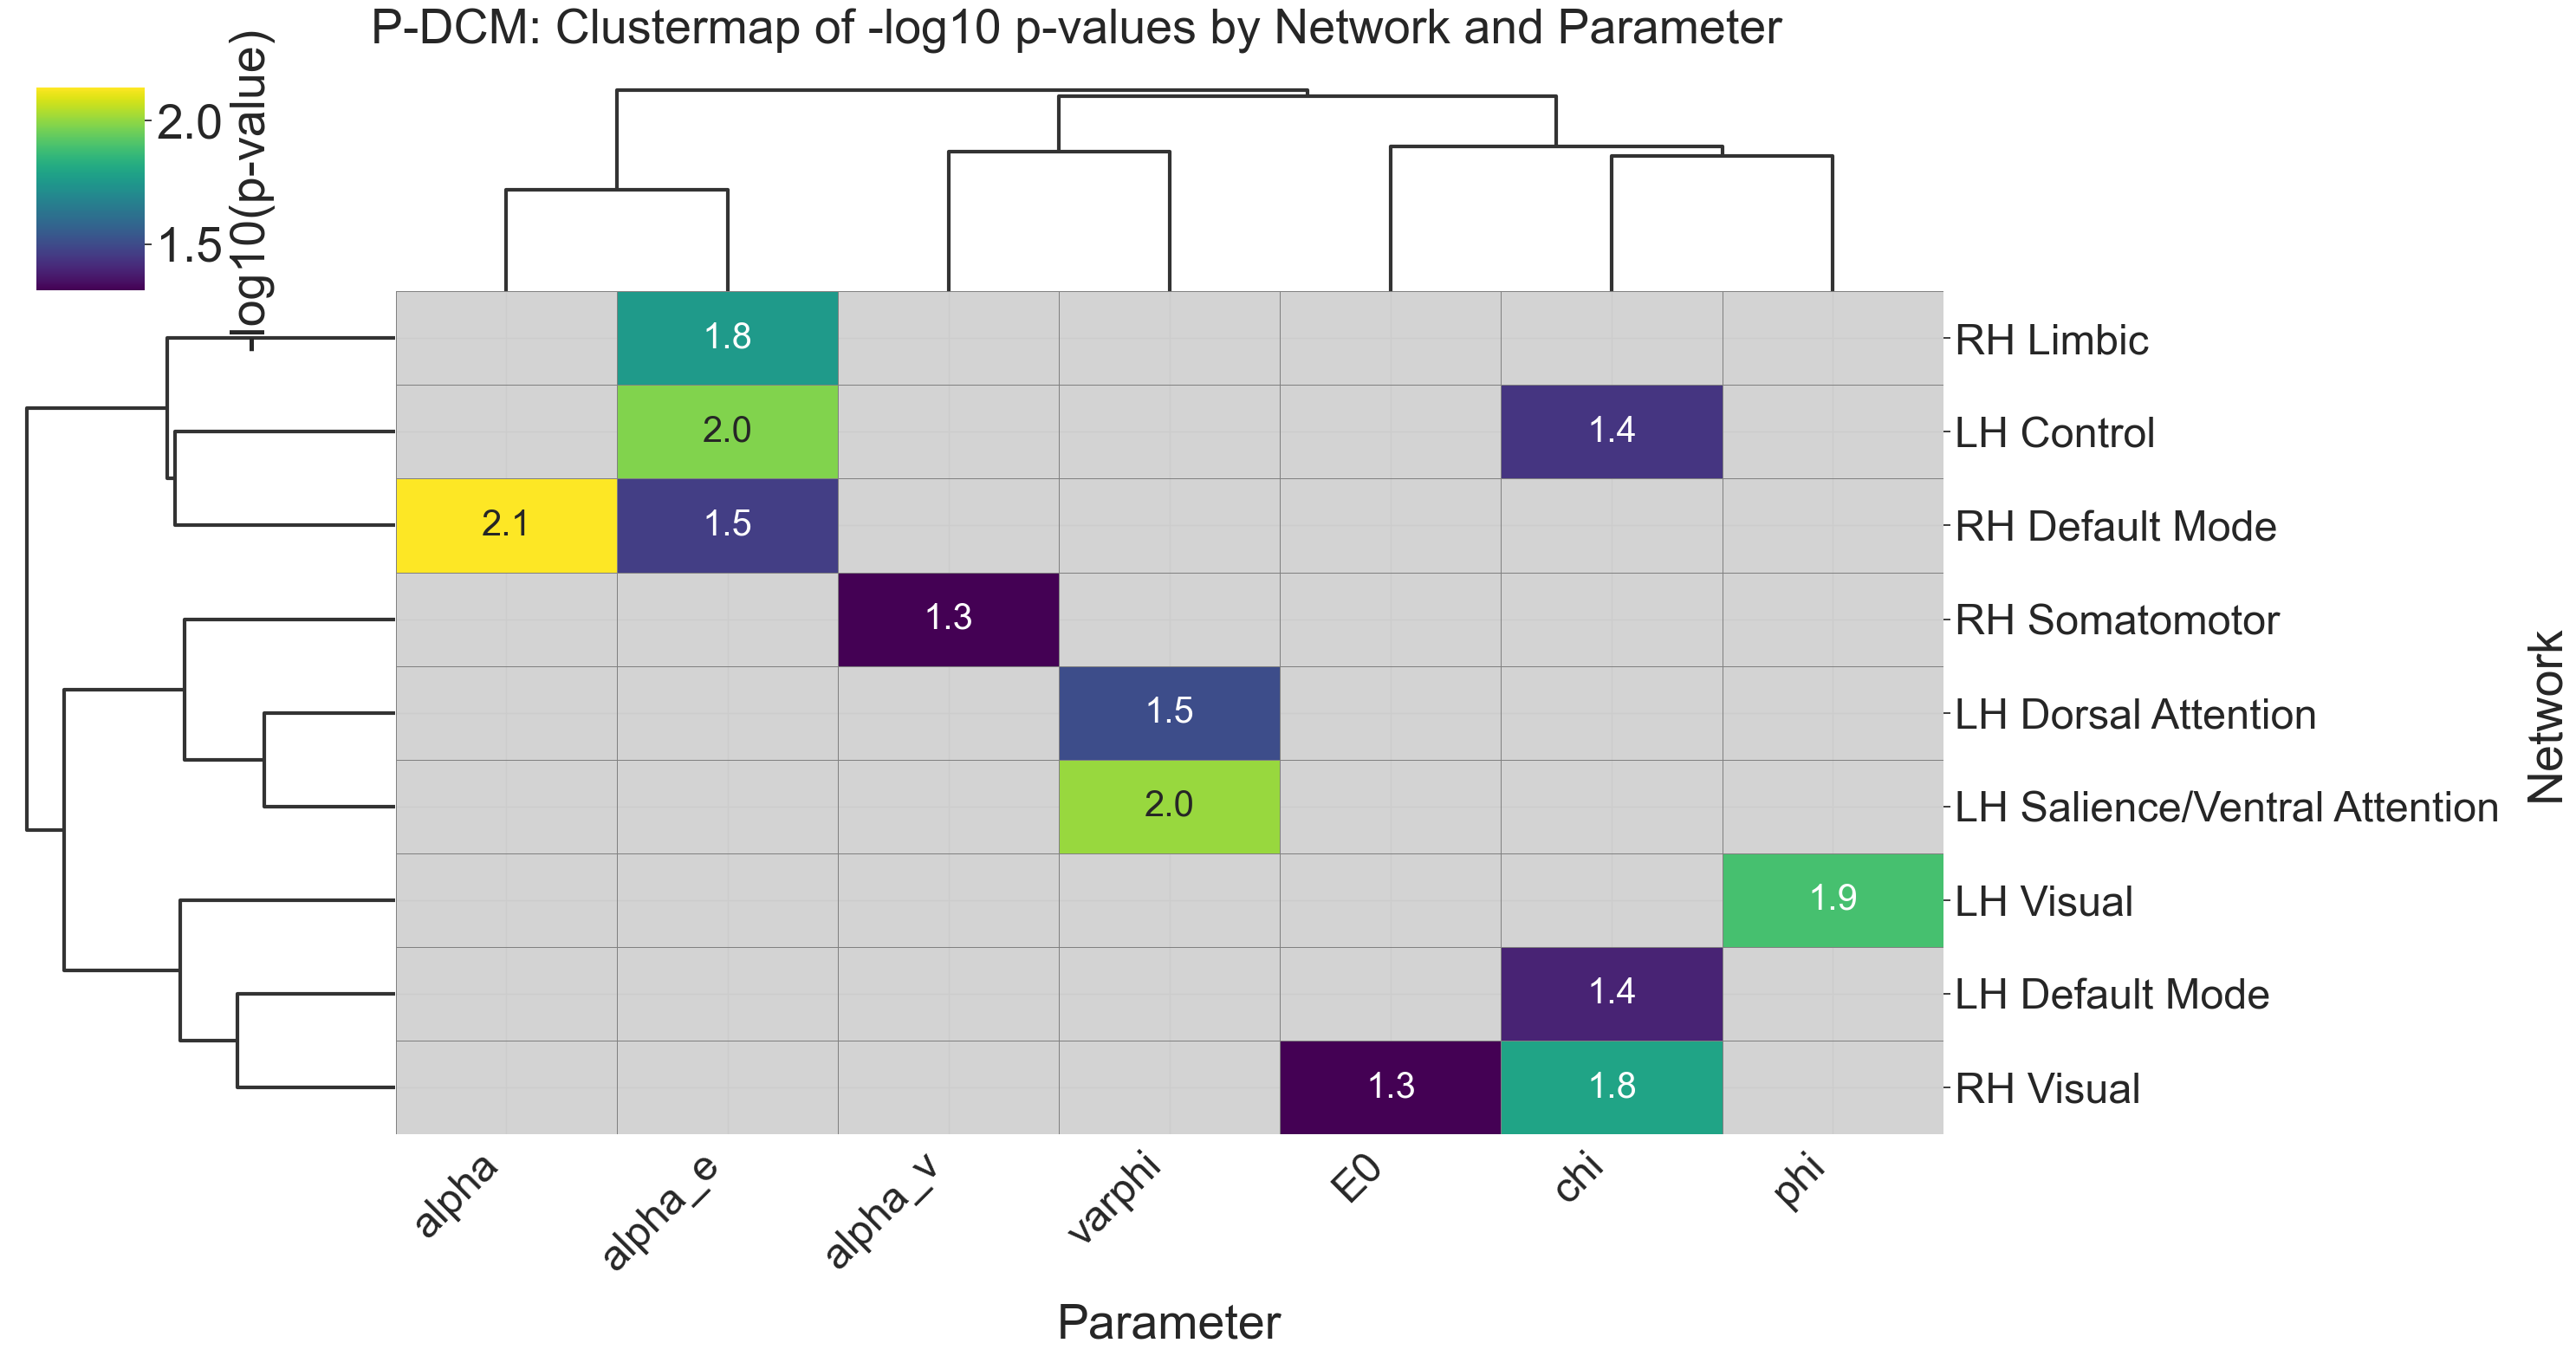

Statistically Significant Network–Parameter Pairs (p < 0.05):
                      network parameter  p_value
              RH Default Mode     alpha 0.007328
LH Salience/Ventral Attention    varphi 0.009814
                   LH Control   alpha_e 0.010474
                    LH Visual       phi 0.012836
                    RH Visual       chi 0.016138
                    RH Limbic   alpha_e 0.017416
          LH Dorsal Attention    varphi 0.031216
              RH Default Mode   alpha_e 0.034406
                   LH Control       chi 0.036425
              LH Default Mode       chi 0.040445
                    RH Visual        E0 0.048551
               RH Somatomotor   alpha_v 0.048643

Row Dendrogram Linkage (Networks):
   Cluster 1  Cluster 2  Distance  Sample Count
0        2.0        3.0  0.940033           2.0
1        1.0        8.0  1.133182           2.0
2        7.0        9.0  1.516055           3.0
3        4.0       10.0  1.547679           3.0
4        0.0        5.0  

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection


pivot_pvals_net = results_df.pivot(index="network", columns="parameter", values="p_value")
log_pvals_net = -np.log10(pivot_pvals_net).sort_index().clip(upper=10)


rename_map = {"lamb": "lambda", "mtt": "tau", "tau": "tau_1"}
log_pvals_net.rename(columns=rename_map, inplace=True)

threshold = 1.3

annot_data = log_pvals_net.copy()
annot_data = annot_data.where(annot_data > threshold, "")
annot_data = annot_data.applymap(lambda x: f"{x:.1f}" if isinstance(x, float) else "")
mask = log_pvals_net <= threshold

cmap = plt.cm.viridis
# Remove rows (networks) with no significant values above threshold
significant_rows = (log_pvals_net > threshold).any(axis=1)
log_pvals_net = log_pvals_net.loc[significant_rows]
annot_data = annot_data.loc[significant_rows]
mask = mask.loc[significant_rows]

# Remove columns (parameters) with no significant values above threshold
significant_cols = (log_pvals_net > threshold).any(axis=0)
log_pvals_net = log_pvals_net.loc[:, significant_cols]
annot_data = annot_data.loc[:, significant_cols]
mask = mask.loc[:, significant_cols]


g_net = sns.clustermap(
    log_pvals_net,
    cmap=cmap,
    figsize=(25, 13),
    yticklabels=True,
    xticklabels=True,
    mask=mask,
    annot=annot_data,
    fmt="",
    annot_kws={"size": 30},
    cbar_kws={"label": "-log10(p-value)"},
    linewidths=0.5,
    linecolor="gray"
)
g_net.ax_heatmap.set_facecolor("lightgray")

for ax in [g_net.ax_col_dendrogram, g_net.ax_row_dendrogram]:
    for collection in ax.collections:
        if isinstance(collection, LineCollection):
            collection.set_linewidth(3.0)


g_net.fig.suptitle(
    "P-DCM: Clustermap of -log10 p-values by Network and Parameter",
    y=1.05, fontsize=40
)

plt.setp(g_net.ax_heatmap.xaxis.get_majorticklabels(), fontsize=35, rotation=45, ha="right")
plt.setp(g_net.ax_heatmap.yaxis.get_majorticklabels(), fontsize=35)

g_net.cax.set_ylabel("-log10(p-value)", fontsize=40)
g_net.cax.tick_params(labelsize=40)

g_net.ax_heatmap.set_xlabel("Parameter", fontsize=40, labelpad=20)
g_net.ax_heatmap.set_ylabel("Network", fontsize=40, labelpad=20)

plt.show()


significant_results = results_df[results_df["p_value"] < 0.05]


significant_summary = significant_results[["network", "parameter", "p_value"]]
significant_summary = significant_summary.sort_values(by="p_value")

print("Statistically Significant Network–Parameter Pairs (p < 0.05):")
print(significant_summary.to_string(index=False))


row_linkage = g_net.dendrogram_row.linkage
row_linkage_df = pd.DataFrame(row_linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
print("\nRow Dendrogram Linkage (Networks):")
print(row_linkage_df)


col_linkage = g_net.dendrogram_col.linkage
col_linkage_df = pd.DataFrame(col_linkage, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])
print("\nColumn Dendrogram Linkage (Parameters):")
print(col_linkage_df)

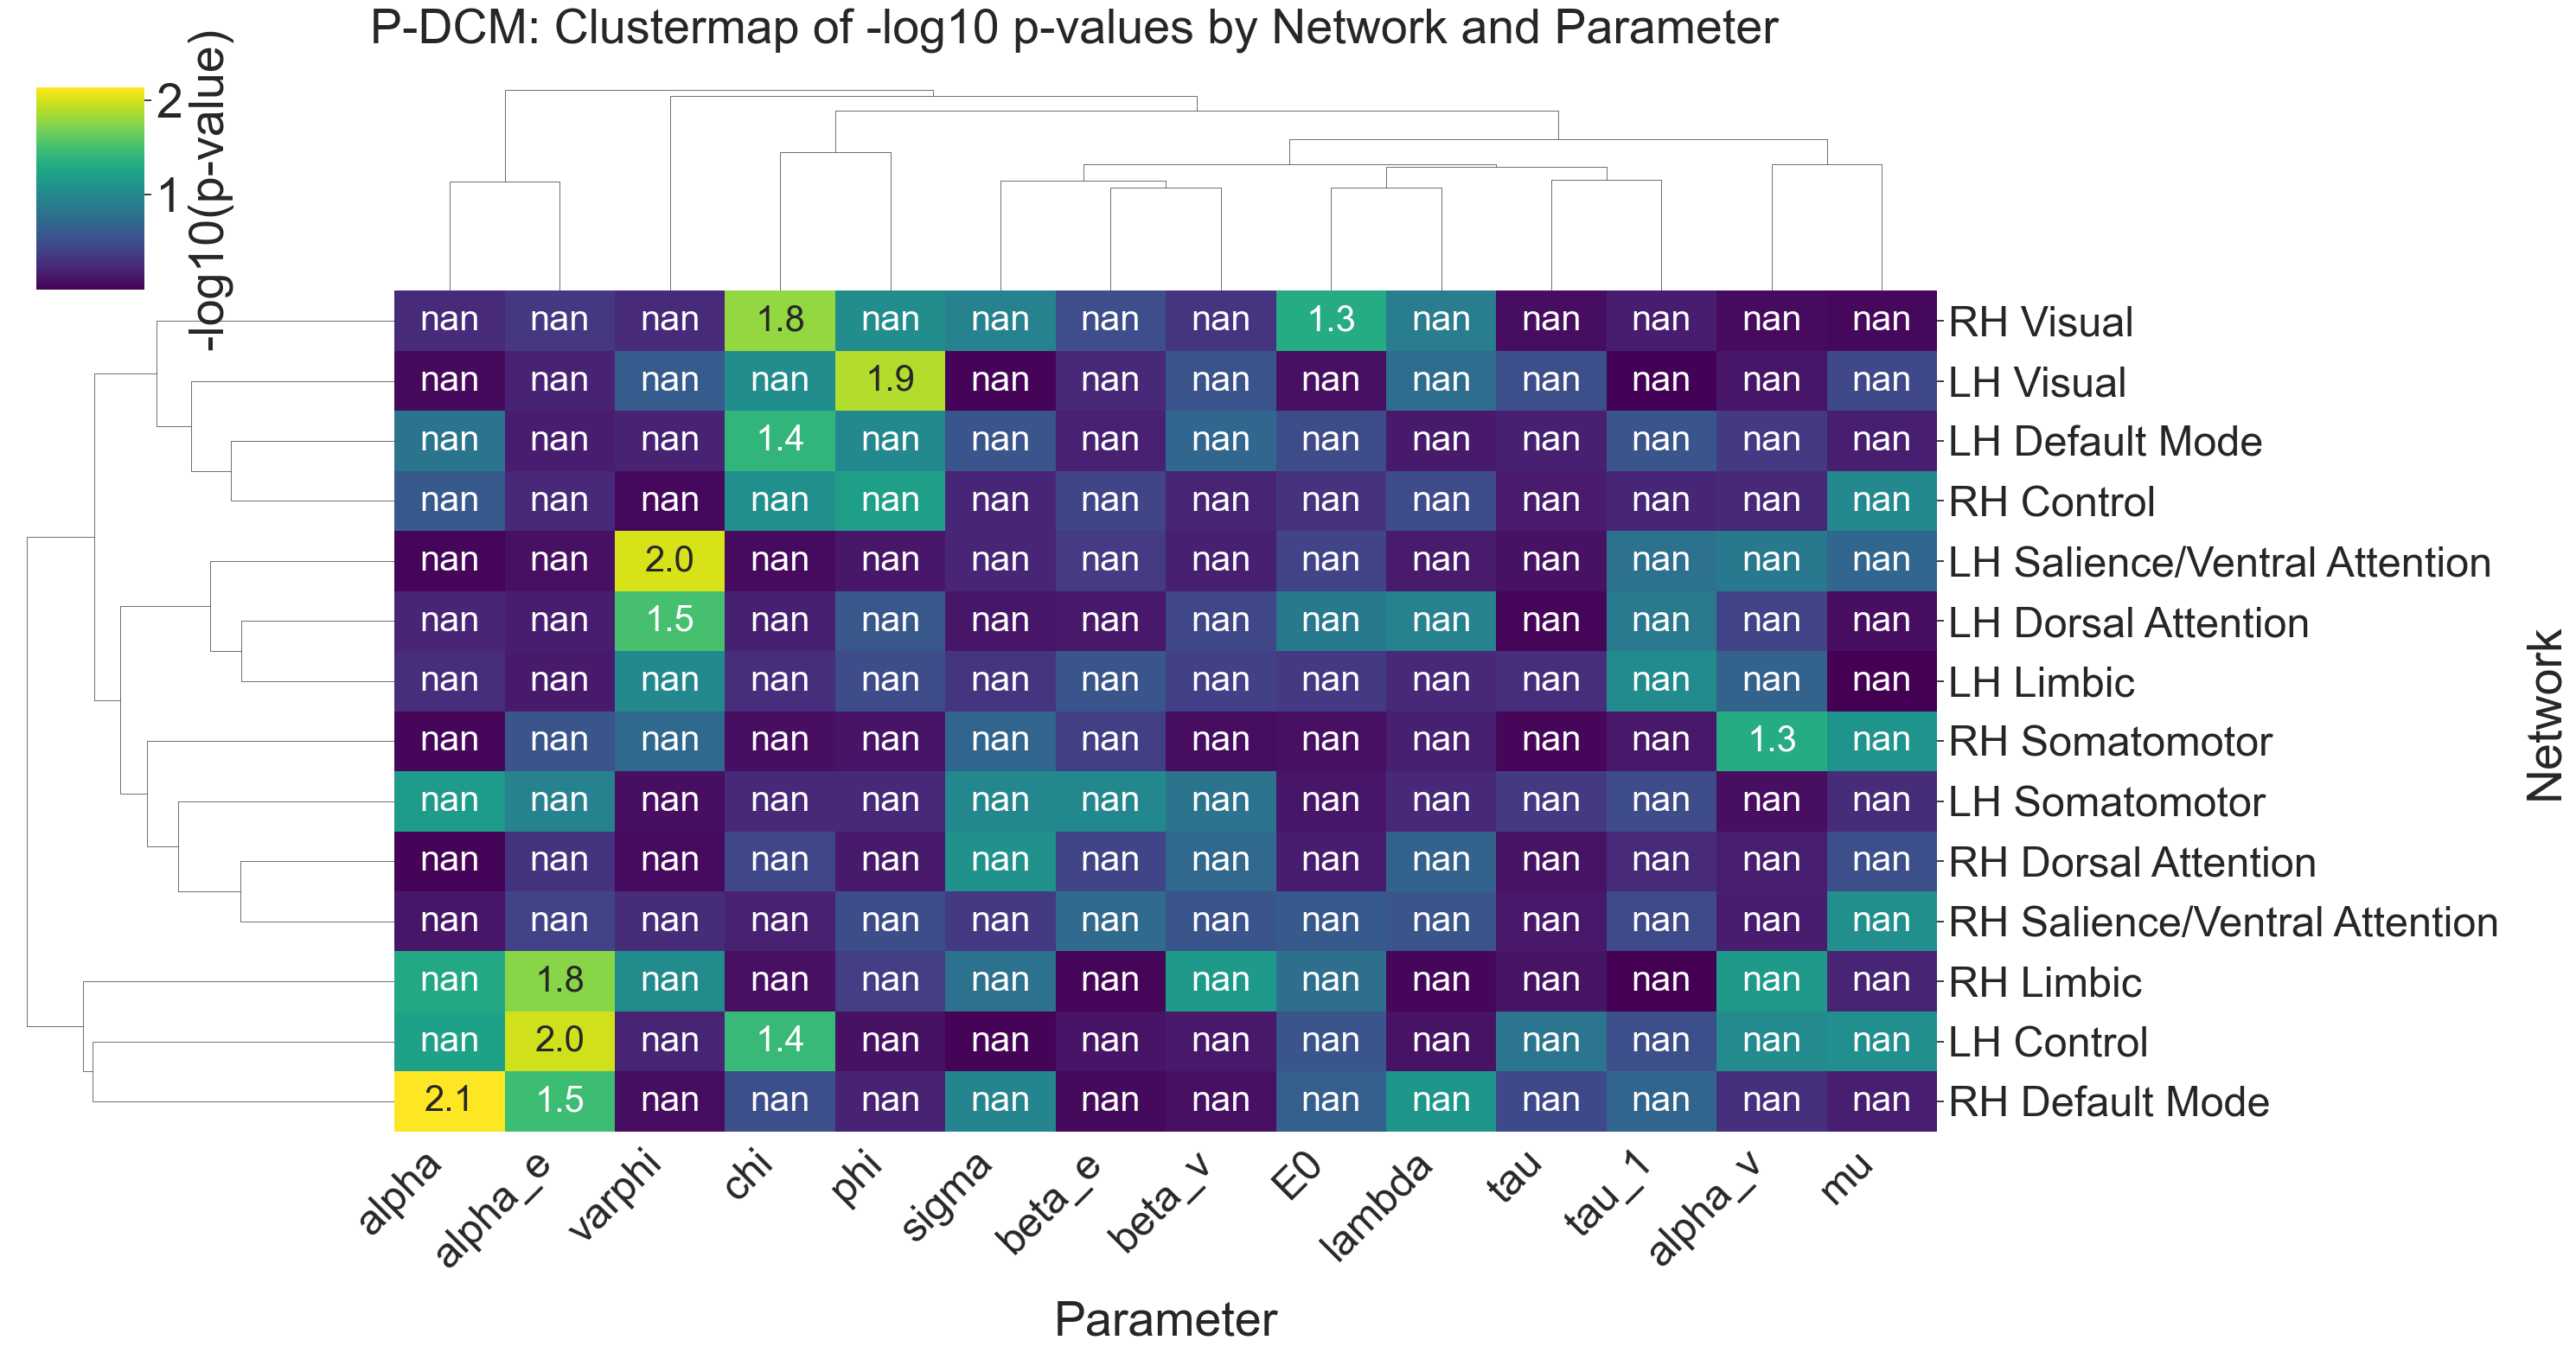

Statistically Significant Network–Parameter Pairs (p < 0.05):
                      network parameter  p_value
              RH Default Mode     alpha 0.007328
LH Salience/Ventral Attention    varphi 0.009814
                   LH Control   alpha_e 0.010474
                    LH Visual       phi 0.012836
                    RH Visual       chi 0.016138
                    RH Limbic   alpha_e 0.017416
          LH Dorsal Attention    varphi 0.031216
              RH Default Mode   alpha_e 0.034406
                   LH Control       chi 0.036425
              LH Default Mode       chi 0.040445
                    RH Visual        E0 0.048551
               RH Somatomotor   alpha_v 0.048643


In [ ]:
# Prepare the log-transformed p-values
pivot_pvals_net = results_df.pivot(index="network", columns="parameter", values="p_value")
log_pvals_net = -np.log10(pivot_pvals_net).sort_index().clip(upper=10)

rename_map = {"lamb": "lambda", "mtt": "tau", "tau": "tau_1"}
log_pvals_net.rename(columns=rename_map, inplace=True)

# Create annotation matrix: only show values > 1.3
annot_vals = log_pvals_net.copy()
annot_vals = annot_vals.where(annot_vals > 1.3, np.nan) 

g_net = sns.clustermap(
    log_pvals_net,
    cmap="viridis",
    figsize=(25, 13),
    yticklabels=True, 
    xticklabels=True, 
    annot=annot_vals,
    fmt=".1f",  
    annot_kws={"size": 30},  
    cbar_kws={"label": "-log10(p-value)"},
)


for ax in [g_net.ax_col_dendrogram, g_net.ax_row_dendrogram]:
    for line in ax.lines:
        line.set_linewidth(5.0)

g_net.fig.suptitle("P-DCM: Clustermap of -log10 p-values by Network and Parameter", y=1.05, fontsize=40)
plt.setp(g_net.ax_heatmap.xaxis.get_majorticklabels(), fontsize=35, rotation=45, ha="right")
plt.setp(g_net.ax_heatmap.yaxis.get_majorticklabels(), fontsize=35)
g_net.cax.set_ylabel("-log10(p-value)", fontsize=40)
g_net.cax.tick_params(labelsize=40)
g_net.ax_heatmap.set_xlabel("Parameter", fontsize=40, labelpad=20)
g_net.ax_heatmap.set_ylabel("Network", fontsize=40, labelpad=20)

plt.show()


significant_results = results_df[results_df["p_value"] < 0.05]


significant_summary = significant_results[["network", "parameter", "p_value"]]


significant_summary = significant_summary.sort_values(by="p_value")


print("Statistically Significant Network–Parameter Pairs (p < 0.05):")
print(significant_summary.to_string(index=False))


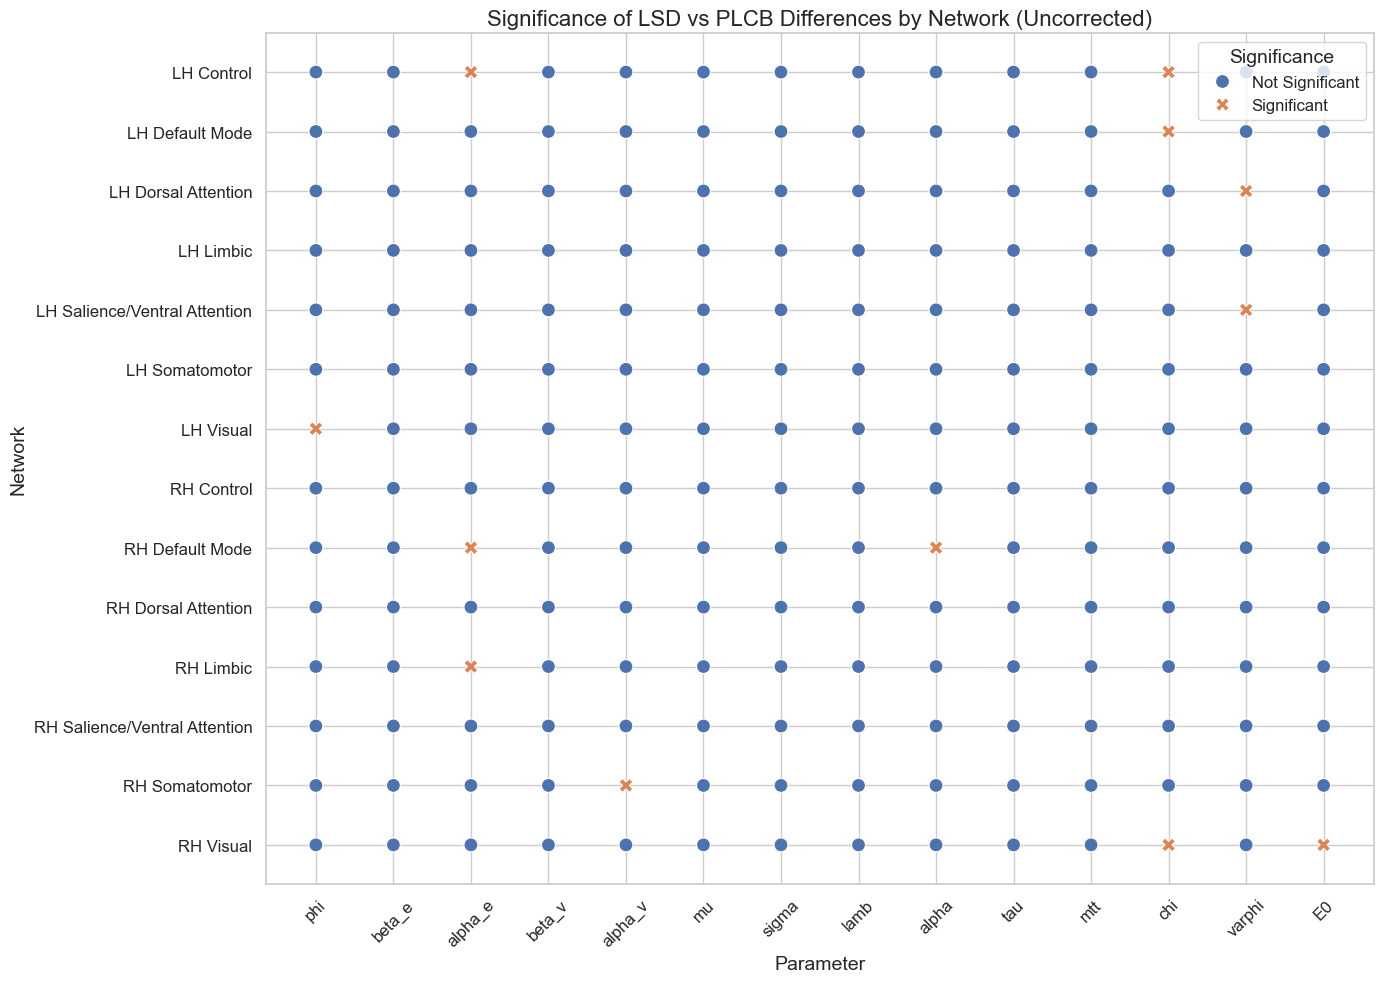

In [68]:
# Mark significance status in results_df
results_df["significance"] = results_df["reject_raw"].map({True: "Significant", False: "Not Significant"})


plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD vs PLCB Differences by Network (Uncorrected)", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Parameter", fontsize=14)
plt.ylabel("Network", fontsize=14)
plt.legend(title="Significance", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


In [69]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests


df = pd.read_csv("pdcm_all_data.csv")

# Parameters to test
params = ["phi", "varphi", "chi", "mtt", "tau",
          "alpha", "E0", "sigma", "mu", "lamb","alpha_v", "beta_v", "alpha_e", "beta_e"]

# Filter and pivot
df_filtered = df[df["parameter"].isin(params)]
df_pivot = df_filtered.pivot_table(
    index=["subject", "roi", "experiment"],
    columns="parameter",
    values="value"
).reset_index()


results = []

for param in params:
    for roi in sorted(df_pivot["roi"].unique()):
        sub_df = df_pivot[df_pivot["roi"] == roi]
        wide = sub_df.pivot(index="subject", columns="experiment", values=param).dropna()

        if wide.shape[0] < 3:
            continue

        diff = wide["LSD"] - wide["PLCB"]
        t_stat, p_val = ttest_rel(wide["LSD"], wide["PLCB"])
        mean_diff = diff.mean()
        std_diff = diff.std(ddof=1)
        cohen_d = mean_diff / std_diff if std_diff != 0 else np.nan

        results.append({
            "roi": roi,
            "parameter": param,
            "mean_diff": mean_diff,
            "std_diff": std_diff,
            "cohen_d": cohen_d,
            "t_stat": t_stat,
            "p_value": p_val
        })


roi_df = pd.DataFrame(results)

# Multiple testing correction
pvals = roi_df["p_value"].fillna(1).values
roi_df["p_fdr_bh"] = multipletests(pvals, method="fdr_bh")[1]
roi_df["p_bonferroni"] = multipletests(pvals, method="bonferroni")[1]
roi_df["p_holm"] = multipletests(pvals, method="holm")[1]

roi_df["reject_raw"] = roi_df["p_value"] < 0.05
roi_df["reject_fdr_bh"] = roi_df["p_fdr_bh"] < 0.05
roi_df["reject_bonferroni"] = roi_df["p_bonferroni"] < 0.05
roi_df["reject_holm"] = roi_df["p_holm"] < 0.05


def interpret_delta(p, mean):
    direction = "↑ LSD > PLCB" if mean > 0 else "↓ LSD < PLCB"
    if p < 0.001:
        return f"highly significant, {direction}"
    elif p < 0.01:
        return f"significant, {direction}"
    elif p < 0.05:
        return f"marginally significant, {direction}"
    else:
        return f"not significant, {direction}"

# Add interpretation columns
roi_df["interpret_raw"] = roi_df.apply(lambda row: interpret_delta(row["p_value"], row["mean_diff"]), axis=1)
roi_df["interpret_fdr_bh"] = roi_df.apply(lambda row: interpret_delta(row["p_fdr_bh"], row["mean_diff"]), axis=1)
roi_df["interpret_bonferroni"] = roi_df.apply(lambda row: interpret_delta(row["p_bonferroni"], row["mean_diff"]), axis=1)
roi_df["interpret_holm"] = roi_df.apply(lambda row: interpret_delta(row["p_holm"], row["mean_diff"]), axis=1)


roi_df = roi_df[[
    "roi", "parameter", "mean_diff", "std_diff", "cohen_d", "t_stat",
    "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

roi_df.sort_values(["roi", "parameter"], inplace=True)
roi_df.reset_index(drop=True, inplace=True)

roi_df


roi parameter  mean_diff   std_diff   cohen_d    t_stat   p_value  \
0       0        E0   0.055975   0.174770  0.320279  1.240434  0.235202   
1       0     alpha  -0.041783   0.176561 -0.236652 -0.916547  0.374899   
2       0   alpha_e  -1.622821   7.065114 -0.229695 -0.889605  0.388709   
3       0   alpha_v  -1.547957   8.506191 -0.181980 -0.704806  0.492491   
4       0    beta_e  -1.022832   2.179009 -0.469402 -1.817987  0.090523   
...   ...       ...        ...        ...       ...       ...       ...   
1395   99        mu   0.519323   0.752881  0.689780  2.181277  0.057056   
1396   99       phi  -0.132633   0.524538 -0.252857 -0.799606  0.444530   
1397   99     sigma   0.291558   0.322434  0.904242  2.859464  0.018797   
1398   99       tau  -3.414116  11.263187 -0.303122 -0.958555  0.362824   
1399   99    varphi  -0.088442   0.363443 -0.243344 -0.769521  0.461302   

      reject_raw                         interpret_raw  p_fdr_bh  \
0          False         not significant, ↑ LSD > PLCB  0.924457   
1          False         not significant, ↓ LSD < PLCB  0.961221   
2          False         not significant, ↓ LSD < PLCB  0.961221   
3          False         not significant, ↓ LSD < PLCB  0.984144   
4          False         not significant, ↓ LSD < PLCB  0.924457   
...          ...                                   ...       ...   
1395       False         not significant, ↑ LSD > PLCB  0.905038   
1396       False         not significant, ↓ LSD < PLCB  0.980916   
1397        True  marginally significant, ↑ LSD > PLCB  0.780099   
1398       False         not significant, ↓ LSD < PLCB  0.961221   
1399       False         not significant, ↓ LSD < PLCB  0.983950   

      reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
0             False  not significant, ↑ LSD > PLCB           1.0   
1             False  not significant, ↓ LSD < PLCB           1.0   
2             False  not significant, ↓ LSD < PLCB           1.0   
3             False  not significant, ↓ LSD < PLCB           1.0   
4             False  not significant, ↓ LSD < PLCB           1.0   
...             ...                            ...           ...   
1395          False  not significant, ↑ LSD > PLCB           1.0   
1396          False  not significant, ↓ LSD < PLCB           1.0   
1397          False  not significant, ↑ LSD > PLCB           1.0   
1398          False  not significant, ↓ LSD < PLCB           1.0   
1399          False  not significant, ↓ LSD < PLCB           1.0   

      reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
0                 False  not significant, ↑ LSD > PLCB     1.0        False   
1                 False  not significant, ↓ LSD < PLCB     1.0        False   
2                 False  not significant, ↓ LSD < PLCB     1.0        False   
3                 False  not significant, ↓ LSD < PLCB     1.0        False   
4                 False  not significant, ↓ LSD < PLCB     1.0        False   
...                 ...                            ...     ...          ...   
1395              False  not significant, ↑ LSD > PLCB     1.0        False   
1396              False  not significant, ↓ LSD < PLCB     1.0        False   
1397              False  not significant, ↑ LSD > PLCB     1.0        False   
1398              False  not significant, ↓ LSD < PLCB     1.0        False   
1399              False  not significant, ↓ LSD < PLCB     1.0        False   

                     interpret_holm  
0     not significant, ↑ LSD > PLCB  
1     not significant, ↓ LSD < PLCB  
2     not significant, ↓ LSD < PLCB  
3     not significant, ↓ LSD < PLCB  
4     not significant, ↓ LSD < PLCB  
...                             ...  
1395  not significant, ↑ LSD > PLCB  
1396  not significant, ↓ LSD < PLCB  
1397  not significant, ↑ LSD > PLCB  
1398  not significant, ↓ LSD < PLCB  
1399  not significant, ↓ LSD < PLCB  

[1400 rows x 18 columns]

In [70]:
# Filter rows where raw p-value is significant
sig_roi = roi_df[roi_df["p_value"] <= 0.05].copy()


sig_roi.sort_values("roi", ascending=False, inplace=True)


sig_roi

roi parameter  mean_diff  std_diff   cohen_d    t_stat   p_value  \
1397   99     sigma   0.291558  0.322434  0.904242  2.859464  0.018797   
1370   97       tau   6.398059  8.047392  0.795048  2.636874  0.024867   
1354   96       phi  -0.245083  0.213790 -1.146375 -3.802095  0.003474   
1316   94        E0  -0.103125  0.136679 -0.754502 -2.502399  0.031318   
1297   92        mu  -0.414451  0.540086 -0.767379 -2.545109  0.029107   
...   ...       ...        ...       ...       ...       ...       ...   
103     7    beta_v  -1.281266  1.755616 -0.729810 -2.826543  0.013458   
94      6       phi   0.267255  0.443934  0.602015  2.331595  0.035175   
61      4    beta_v  -0.750160  0.866548 -0.865688 -3.352794  0.004738   
23      1        mu  -0.306152  0.484761 -0.631552 -2.445989  0.028261   
6       0       chi   0.184047  0.284076  0.647880  2.509229  0.025016   

      reject_raw                         interpret_raw  p_fdr_bh  \
1397        True  marginally significant, ↑ LSD > PLCB  0.780099   
1370        True  marginally significant, ↑ LSD > PLCB  0.813854   
1354        True             significant, ↓ LSD < PLCB  0.634625   
1316        True  marginally significant, ↓ LSD < PLCB  0.813854   
1297        True  marginally significant, ↓ LSD < PLCB  0.813854   
...          ...                                   ...       ...   
103         True  marginally significant, ↓ LSD < PLCB  0.780099   
94          True  marginally significant, ↑ LSD > PLCB  0.820746   
61          True             significant, ↓ LSD < PLCB  0.634625   
23          True  marginally significant, ↓ LSD < PLCB  0.813854   
6           True  marginally significant, ↑ LSD > PLCB  0.813854   

      reject_fdr_bh               interpret_fdr_bh  p_bonferroni  \
1397          False  not significant, ↑ LSD > PLCB           1.0   
1370          False  not significant, ↑ LSD > PLCB           1.0   
1354          False  not significant, ↓ LSD < PLCB           1.0   
1316          False  not significant, ↓ LSD < PLCB           1.0   
1297          False  not significant, ↓ LSD < PLCB           1.0   
...             ...                            ...           ...   
103           False  not significant, ↓ LSD < PLCB           1.0   
94            False  not significant, ↑ LSD > PLCB           1.0   
61            False  not significant, ↓ LSD < PLCB           1.0   
23            False  not significant, ↓ LSD < PLCB           1.0   
6             False  not significant, ↑ LSD > PLCB           1.0   

      reject_bonferroni           interpret_bonferroni  p_holm  reject_holm  \
1397              False  not significant, ↑ LSD > PLCB     1.0        False   
1370              False  not significant, ↑ LSD > PLCB     1.0        False   
1354              False  not significant, ↓ LSD < PLCB     1.0        False   
1316              False  not significant, ↓ LSD < PLCB     1.0        False   
1297              False  not significant, ↓ LSD < PLCB     1.0        False   
...                 ...                            ...     ...          ...   
103               False  not significant, ↓ LSD < PLCB     1.0        False   
94                False  not significant, ↑ LSD > PLCB     1.0        False   
61                False  not significant, ↓ LSD < PLCB     1.0        False   
23                False  not significant, ↓ LSD < PLCB     1.0        False   
6                 False  not significant, ↑ LSD > PLCB     1.0        False   

                     interpret_holm  
1397  not significant, ↑ LSD > PLCB  
1370  not significant, ↑ LSD > PLCB  
1354  not significant, ↓ LSD < PLCB  
1316  not significant, ↓ LSD < PLCB  
1297  not significant, ↓ LSD < PLCB  
...                             ...  
103   not significant, ↓ LSD < PLCB  
94    not significant, ↑ LSD > PLCB  
61    not significant, ↓ LSD < PLCB  
23    not significant, ↓ LSD < PLCB  
6     not significant, ↑ LSD > PLCB  

[73 rows x 18 columns]

In [71]:
# Bonferroni 
sig_bonf_roi = roi_df[roi_df["reject_bonferroni"] == True]
sig_bonf_roi


Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [72]:
# FDR BH significant
sig_fdr_roi = roi_df[roi_df["reject_fdr_bh"] == True]
sig_fdr_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [73]:
sig_holm_roi = roi_df[roi_df["reject_holm"] == True]
sig_holm_roi 

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

In [74]:
consistently_sig_roi = roi_df[
    (roi_df["reject_raw"] == True) &
    (roi_df["reject_fdr_bh"] == True) &
    (roi_df["reject_bonferroni"] == True) &
    (roi_df["reject_holm"] == True)
]
consistently_sig_roi

Empty DataFrame
Columns: [roi, parameter, mean_diff, std_diff, cohen_d, t_stat, p_value, reject_raw, interpret_raw, p_fdr_bh, reject_fdr_bh, interpret_fdr_bh, p_bonferroni, reject_bonferroni, interpret_bonferroni, p_holm, reject_holm, interpret_holm]
Index: []

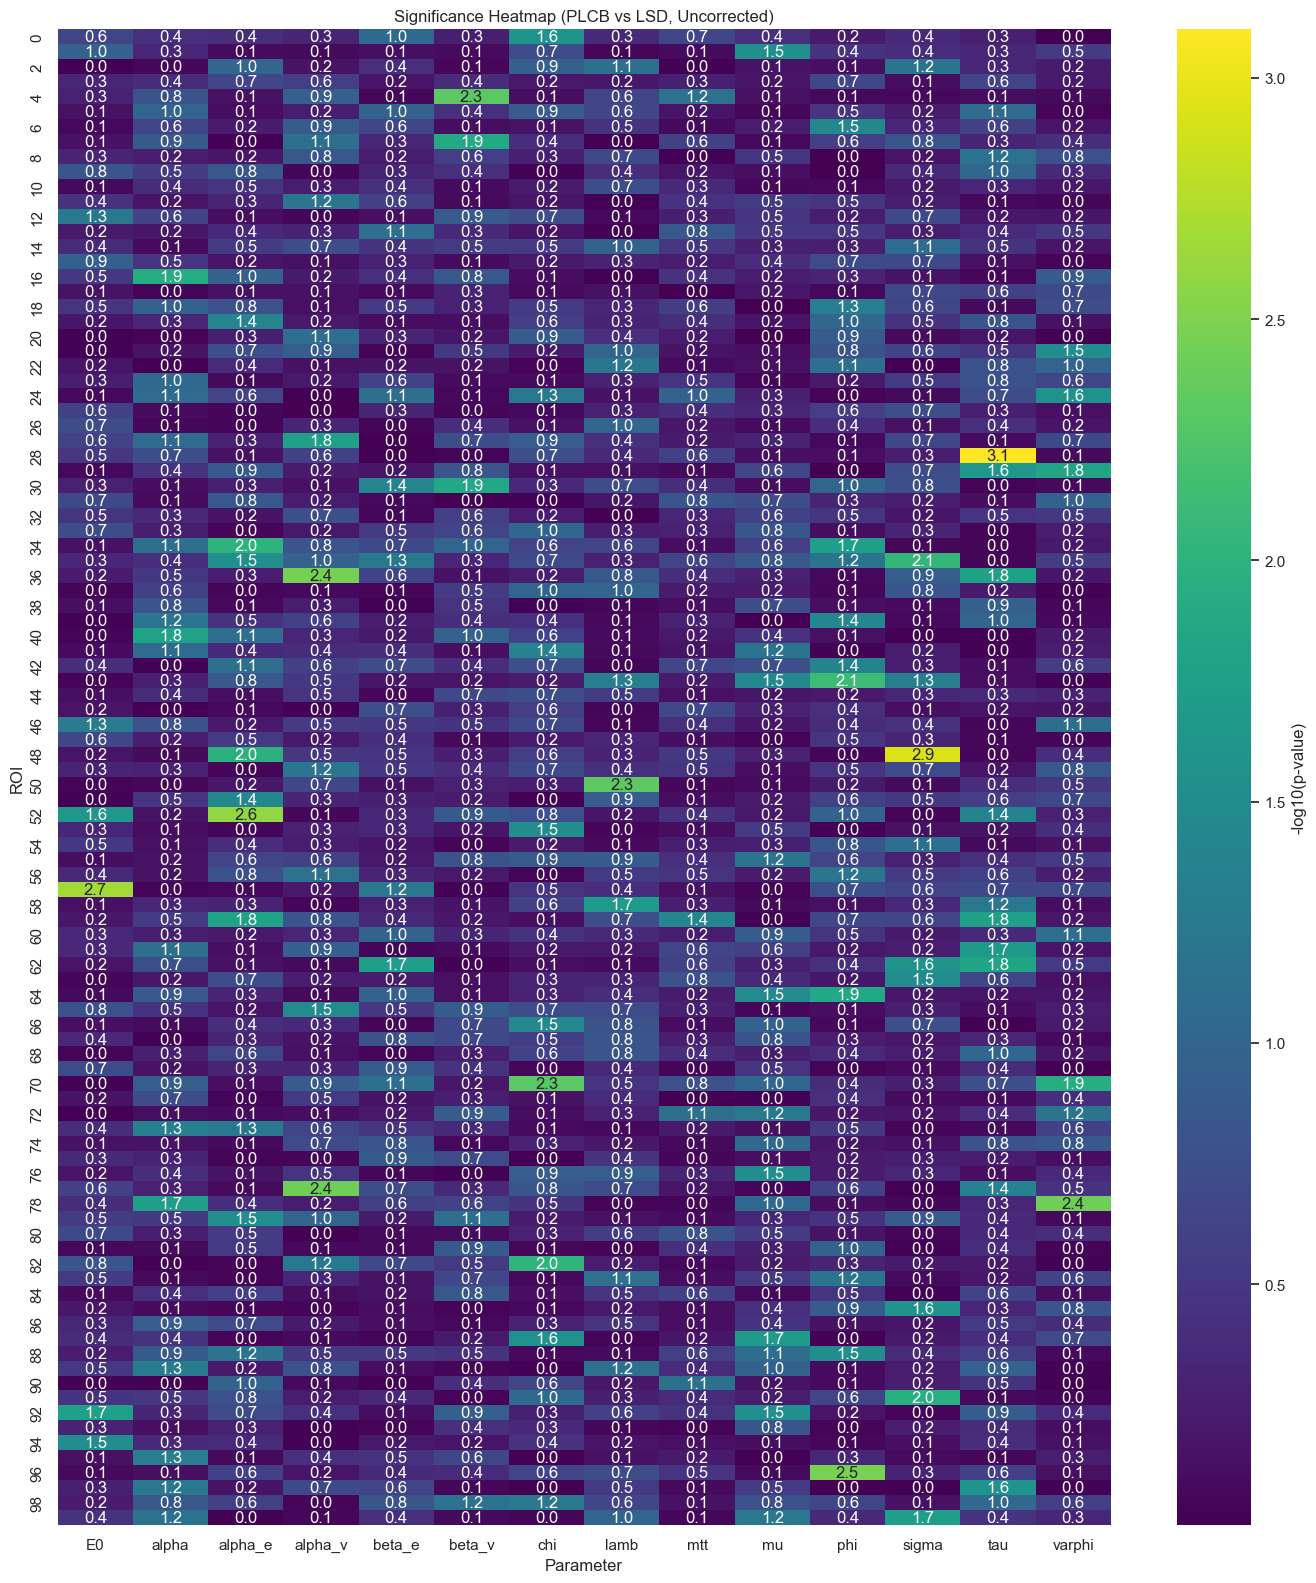

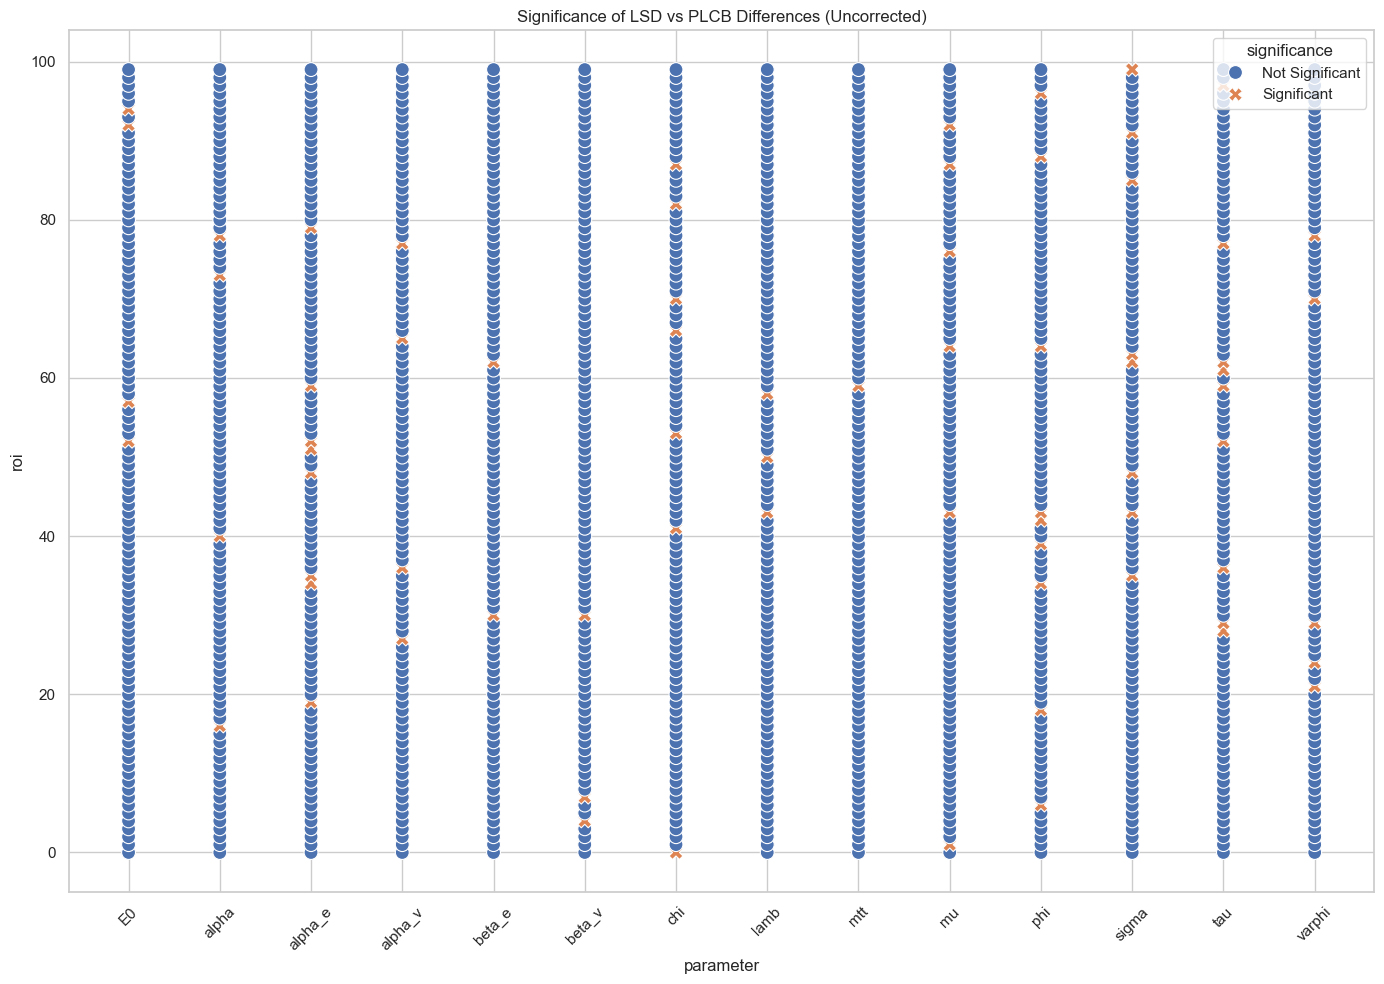

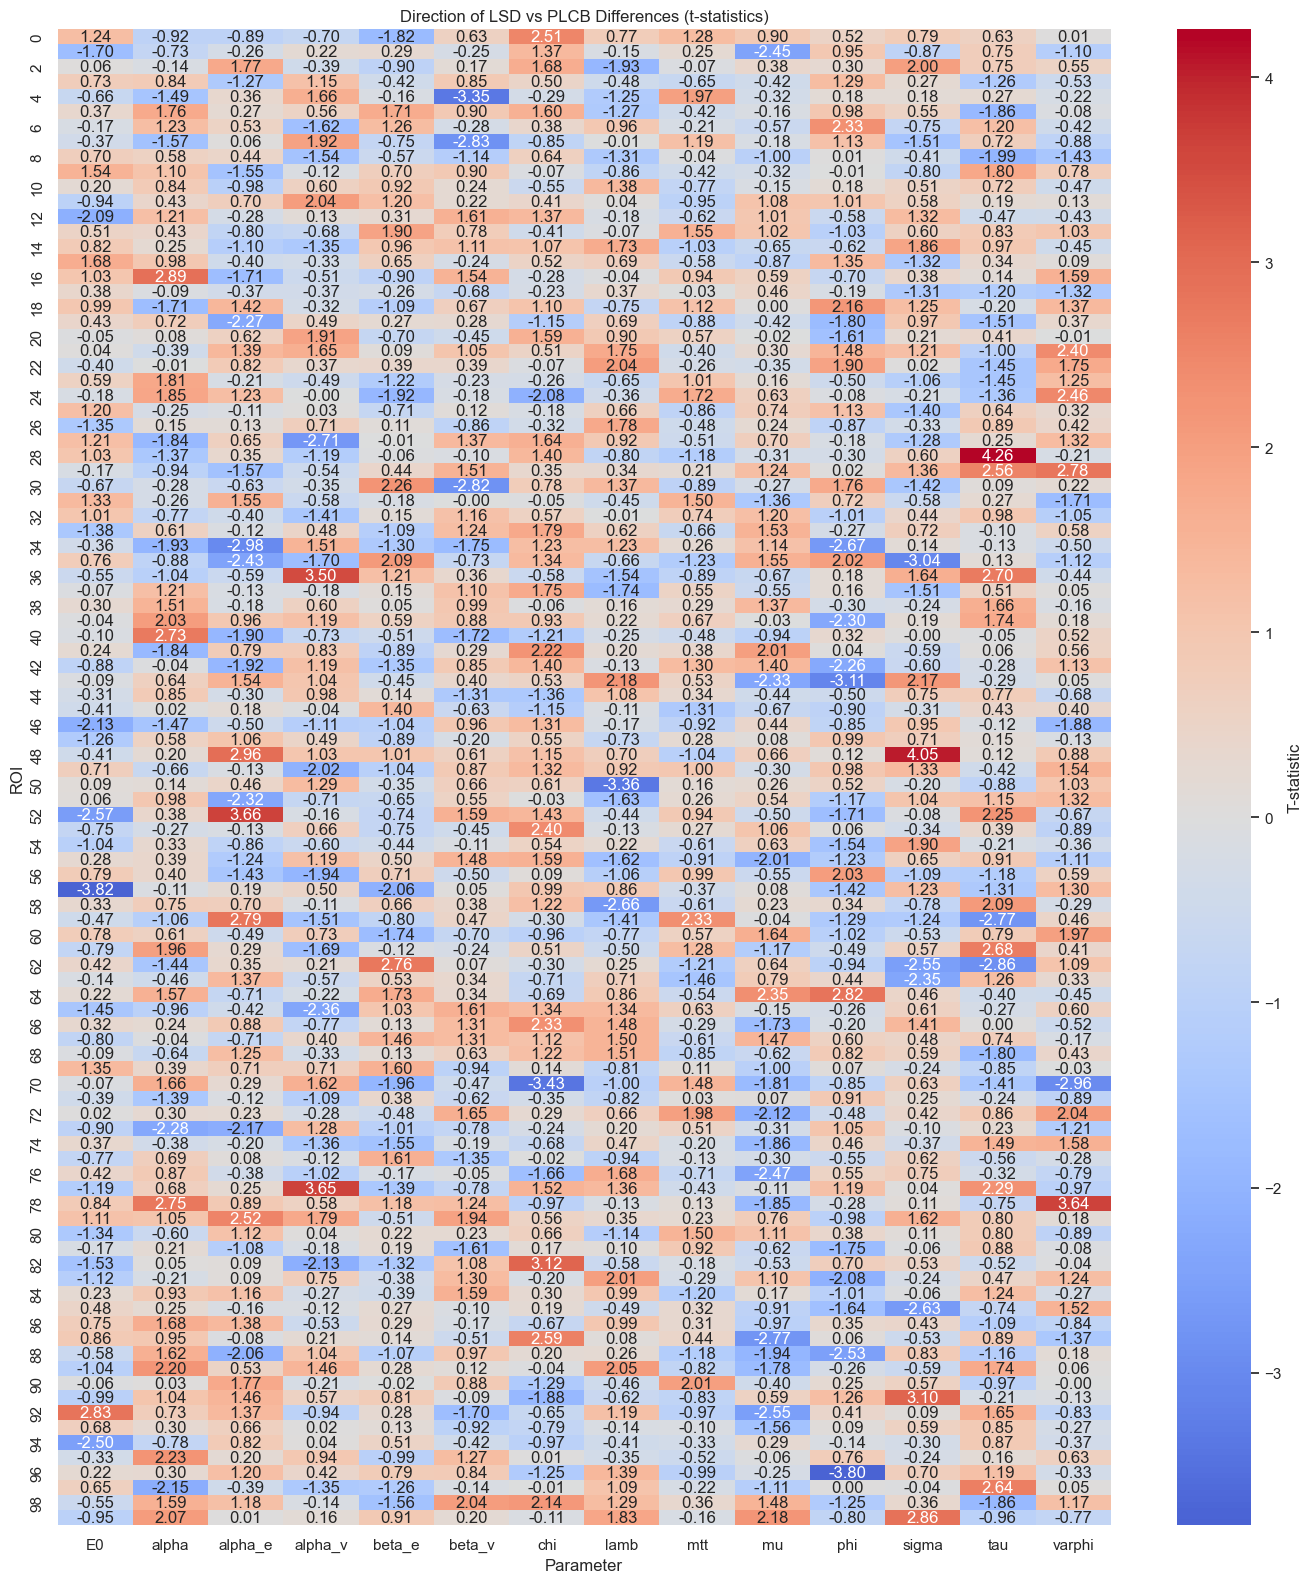

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot to ROI × parameter matrix of p-values
heatmap_df = roi_df.pivot(index="roi", columns="parameter", values="p_value")

# Convert p-values to -log10 scale (clip very low to avoid inf)
log_pvals = -np.log10(heatmap_df.clip(lower=1e-10))

plt.figure(figsize=(14, 16))
sns.heatmap(
    log_pvals,
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs LSD, Uncorrected)")
plt.ylabel("ROI")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

roi_df["significance"] = roi_df["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=roi_df,
    x="parameter", y="roi",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD vs PLCB Differences (Uncorrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pivot to ROI × parameter matrix of t-statistics
t_stat_matrix = roi_df.pivot(index="roi", columns="parameter", values="t_stat")

plt.figure(figsize=(14, 16))
sns.heatmap(
    t_stat_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "T-statistic"}
)
plt.title("Direction of LSD vs PLCB Differences (t-statistics)")
plt.ylabel("ROI")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()
